Timetracking: 6h

In [2]:
import pandas as pd
import joblib
import shap
from shap.maskers import Independent
import matplotlib.pyplot as plt
from comparers import ModelComparer, plot_decision_boundary, _encode_one_hot, _calc_log_odds_from_log_proba
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order, plot_2d, \
                       plot_feature_importance_bar, plot_feature_importance_scatter, plot_feature_effects, plot_forces, \
                       merge_explanations
import numpy as np
import pandas as pd
import pickle
import cloudpickle
from matplotlib.colors import Normalize
import scipy as sp
from util import get_rules
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.cm as cm
shap.initjs()
%matplotlib inline
task_name = '02'

In [3]:
try:
    with open(task_name + '.models', 'rb') as f:
        comparer = pickle.load(f)
    with open(task_name + '.expl', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite = pickle.load(f)
    is_pred_diff = comparer.predict_bin_diff(explanations.data)
    mclass_diff = comparer.predict_mclass_diff(explanations.data)
except FileNotFoundError:
    pass

In [4]:
X = pd.read_csv('test_data.csv')
y = X['price']
X = X.drop(columns=['Unnamed: 0', 'price'])
feature_names = X.columns.to_numpy()
class_names = y.unique().astype(str)
X

CRIM   ZN      INDUS       NOX        RM  AGE       DIS        RAD  \
0     5.438165  0.0  18.100000  0.713000  6.395536  2.0  2.331054  24.000000   
1    10.062300  0.0  18.100000  0.584000  6.833000  2.0  2.088200  24.000000   
2     0.402020  0.0   9.900000  0.544000  6.382000  1.0  3.532500   4.000000   
3     0.290900  0.0  21.890000  0.624000  6.174000  2.0  1.611900   4.000000   
4     0.250659  0.0   9.542886  0.532534  5.743817  1.0  4.153345   3.880564   
..         ...  ...        ...       ...       ...  ...       ...        ...   
241   6.801170  0.0  18.100000  0.713000  6.081000  1.0  2.717500  24.000000   
242   0.402820  0.0   6.200000  0.504000  8.137837  2.0  3.169809   8.000000   
243   3.774980  0.0  18.100000  0.655000  5.952000  1.0  2.871500  24.000000   
244   0.344745  0.0  21.890000  0.624000  5.685295  2.0  1.814662   4.000000   
245   1.232470  0.0   8.140000  0.538000  6.142000  2.0  3.976900   4.000000   

            TAX    PTRATIO      LSTAT  
0    666.000000  20.200000  16.525663  
1    666.000000  20.200000  19.690000  
2    304.000000  18.400000  10.360000  
3    437.000000  21.200000  24.160000  
4    295.520027  18.340282  12.371885  
..          ...        ...        ...  
241  666.000000  20.200000  14.700000  
242  307.000000  17.400000   3.344242  
243  666.000000  20.200000  17.150000  
244  437.000000  21.200000  17.348228  
245  307.000000  21.000000  18.720000  

[246 rows x 11 columns]

In [5]:
clf_a = joblib.load('model_A.joblib')
clf_b = joblib.load('model_B.joblib')

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


# Comparing decision boundaries of two different classifier models

In [5]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)
with open(task_name + '.models', 'wb') as f:
    cloudpickle.dump(comparer, f, pickle.HIGHEST_PROTOCOL)

Let's plot all feature against all other features and color the instances red, that have different predictions:

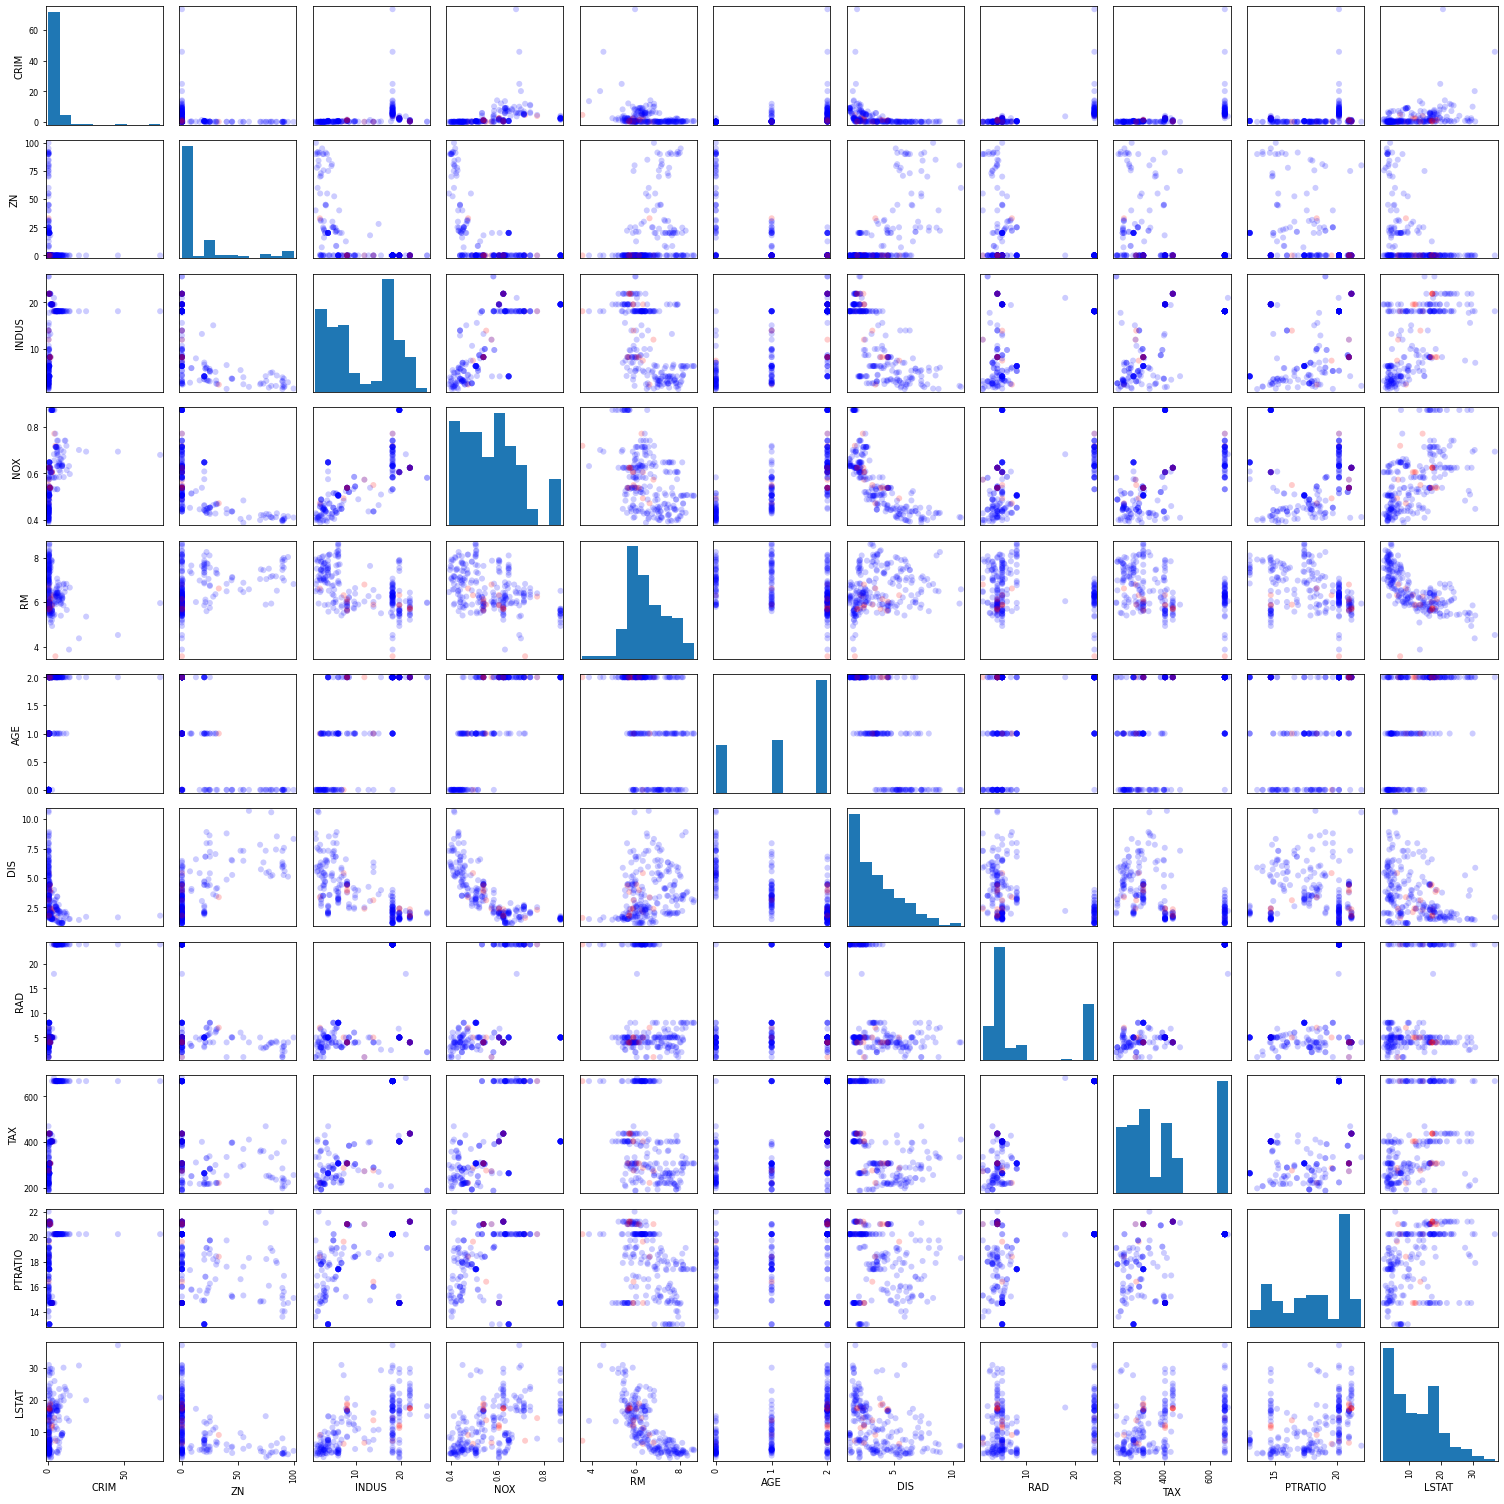

In [6]:
df = pd.DataFrame(X, columns=feature_names)
cmap = plt.get_cmap('rainbow')
is_pred_diff = comparer.predict_bin_diff(X)
colors = ['r' if v else 'b' for v in is_pred_diff]
axes = pd.plotting.scatter_matrix(df, figsize=(21, 21), marker='o', alpha=0.2, c=colors)
plt.tight_layout()

It's too difficult to impose any structure on this.

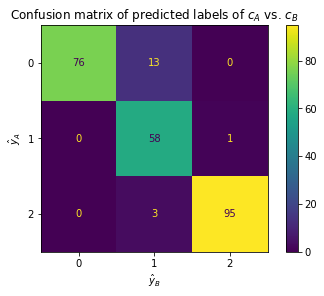

In [7]:
comparer.plot_confusion_matrix(X)

In the modified confusion plot of A vs. B's predictions, we see that most (13) instances fall into the confusion class $(0, 1)$, 3 into $(2, 1)$ and 1 into $(1, 2)$.

# Generate SHAP values

In [8]:
%%time
masker = Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])
with open(task_name + '.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite),
                f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 247it [00:23,  6.83it/s]                         
Permutation explainer: 247it [00:23,  5.21it/s]                         
Permutation explainer: 247it [00:49,  3.92it/s]                         

CPU times: user 2min 13s, sys: 13 s, total: 2min 26s
Wall time: 1min 35s


As we can see, no instances had infinite log-space predictions and no instances had infinite SHAP values:

In [9]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((246, 11), (0,), (0,))

In [10]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)

In [6]:
feature_idx_of = lambda feature_name: np.where(comparer.feature_names == feature_name)[0][0]
class_idx_of = lambda class_name: np.where(comparer.class_names == class_name)[0][0]

# Global Explanations

## Feature importance

### Individual explanations

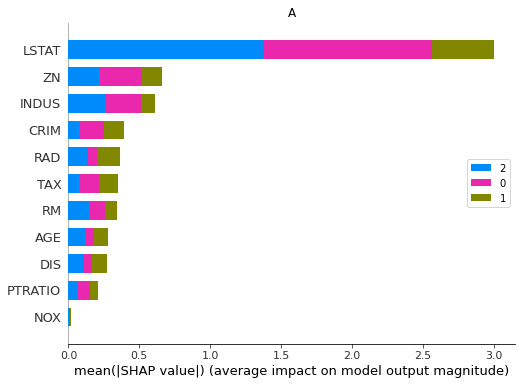

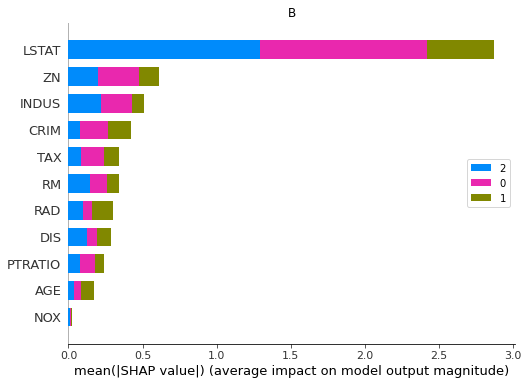

In [79]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds)
plot_feature_importance_bar(explanations.indiv.log_odds.A, title='A', feature_order=feature_order)
plot_feature_importance_bar(explanations.indiv.log_odds.B, title='B', feature_order=feature_order)

Interestingly, AGE has the highest absolute mean SHAP value difference ($A-B$). Above, we also spot that AGE ranks higher in model A.

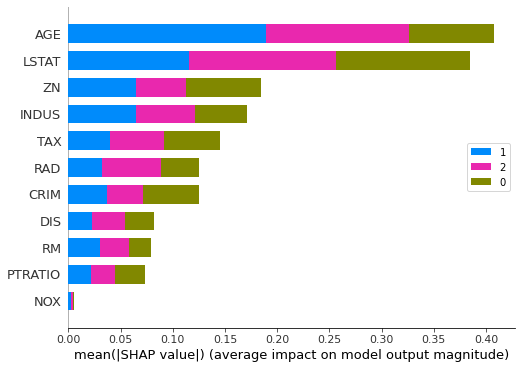

In [14]:
plot_feature_importance_bar(explanations.indiv_diff.log_odds)

### Difference classifier explanations

First, let's derive a feature order from their ranks according to their importances, that is, their mean absolute SHAP values for the difference classifier across all classes.

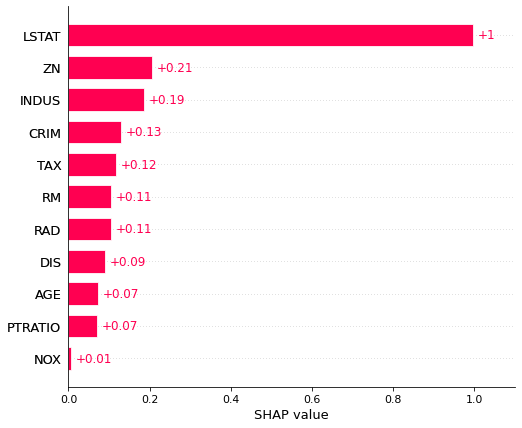

In [8]:
feature_order, feature_importance = calc_feature_order(explanations.mclass_diff.log_odds)
plot_feature_importance_bar(feature_importance)

When inspecting the mean absolute SHAP values per confusion class, AGE now ranks higher than before.

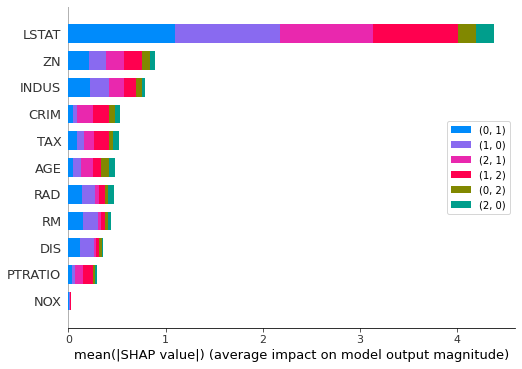

In [16]:
plot_feature_importance_bar(explanations.mclass_diff.log_odds[:, :, comparer.difference_class_names])

For the observed difference in the confusion classes, the SHAP value distribution of LSTAT tells us the following:
- $(0, 1)$: For instances with high feature values, there are increased log odds for this class.
- $(1, 2)$: For instances with with low feature values, there are increased log odds for this class.
- $(2, 1)$: For instances with low feature values, there are increased log odds for this class.

(log odds +1 is approx. +70%)

It's interesting to note, that although confusion classes $(0, 2)$ and $(2, 0)$  have very small SHAP values, they aren't 0. But they are probably very far from being actually classified for any instance, with LSTAT being the main force. Furthermore $(1, 0)$ is about equal in its distribution like $(0, 1)$, even if there are no actual instances that fall into that category. This is because we are looking at log odds (or transformed probabilities), it's still possible that other forces lower the impact and no instance classifies as this class.

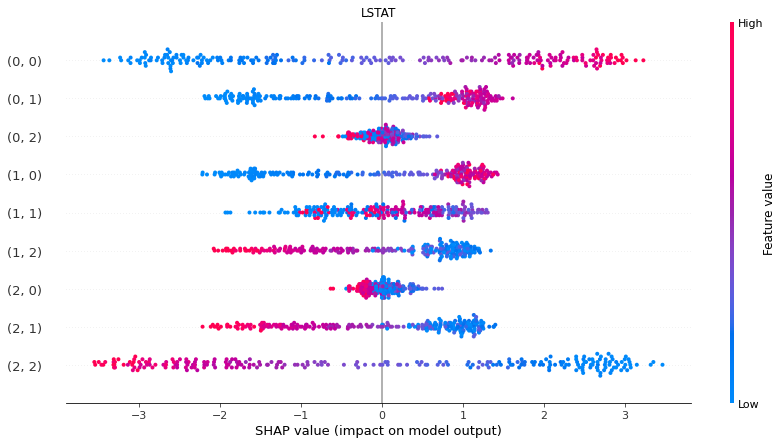

In [17]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[:1]])

For ZN, we see that only instances with high feature values have increased log odds for classes $(1,2)$ and $(2,1)$. But overall the influences are a lot smaller than for LSTAT.

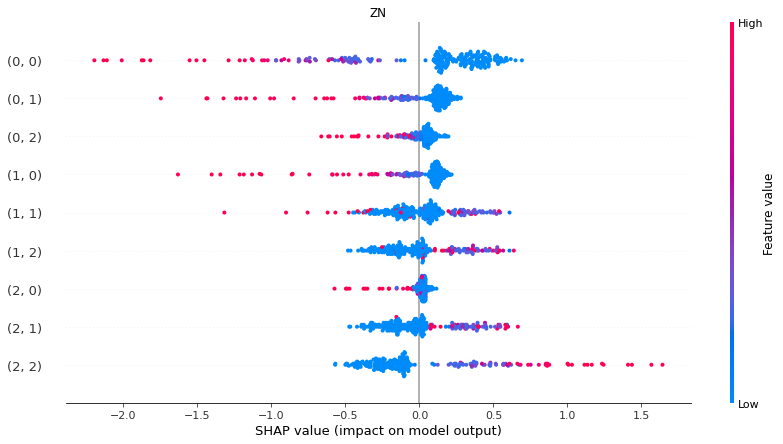

In [18]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[1:2]])

INDUS has positive influence for instances with high feature values for classes $(0,1)$ and $(1,0)$, and also for instances with low feature values for classes $(1,2)$ and $(2,1)$.

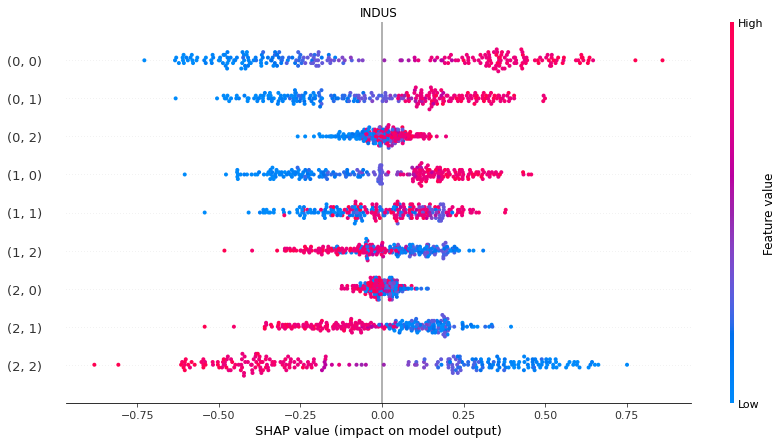

In [19]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[2:3]])

For CRIM it looks very much like for INDUS, except that the distribution is not balanced (there are many instances with low feature values)

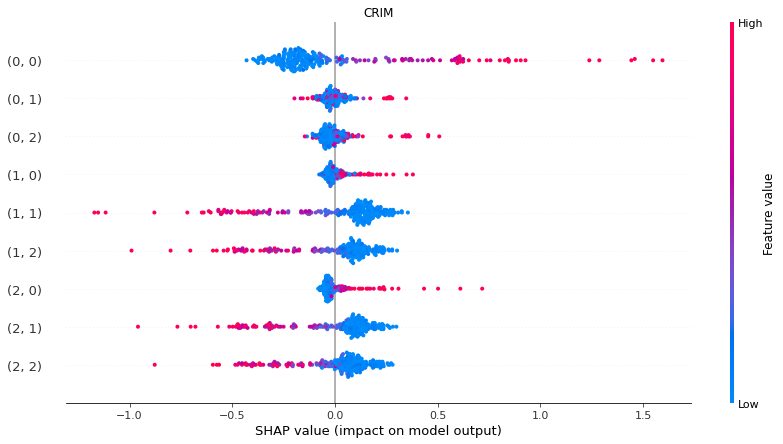

In [9]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[3:4]])

TAX has positive influence for instances with high feature values for classes $(1,2)$ and $(2,1)$.

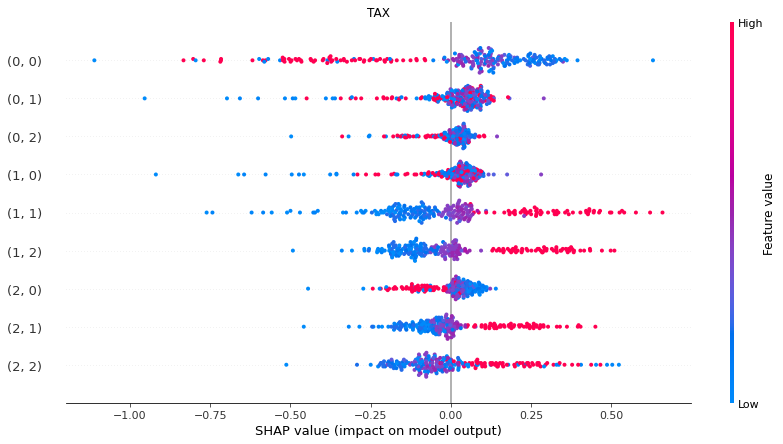

In [21]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[4:5]])

RM has positive influence for instances with low feature values for classes $(0,1)$ and $(1,0)$

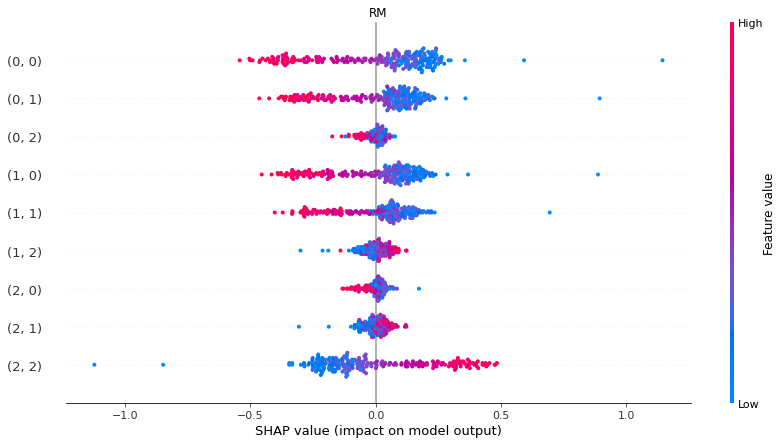

In [22]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[5:6]])

For RAD we observe similar influences.

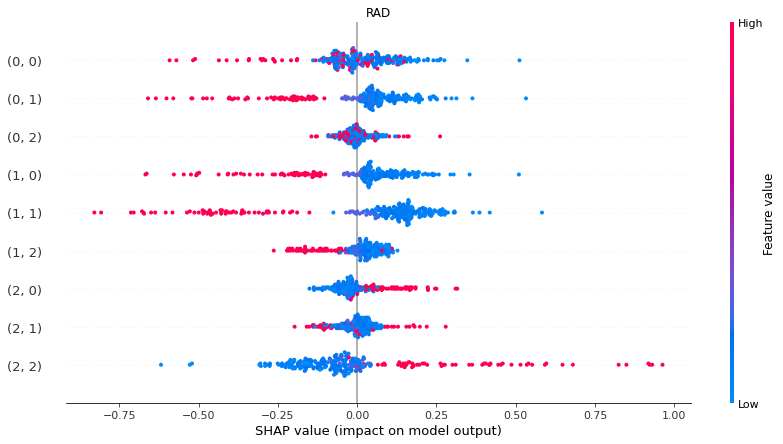

In [23]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[6:7]])

For DIS, we observe similar influences but for instances with high feature values.

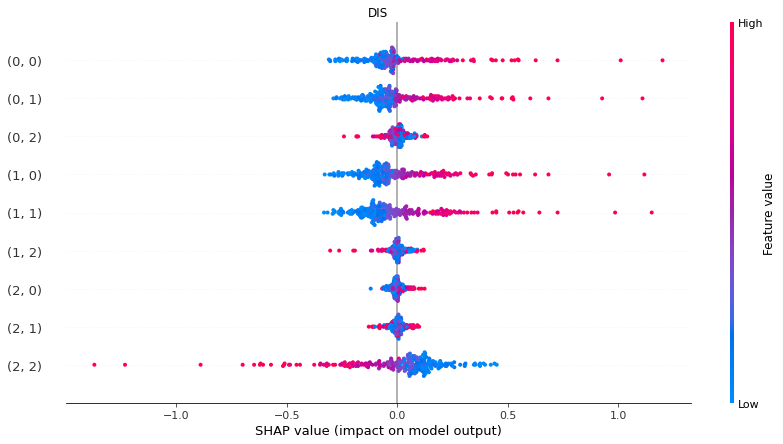

In [24]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[7:8]])

We can see the influences for the lowest AGE group being positive for class $(1,2)$, and for the highest AGE group being positive for class $(2,1)$.

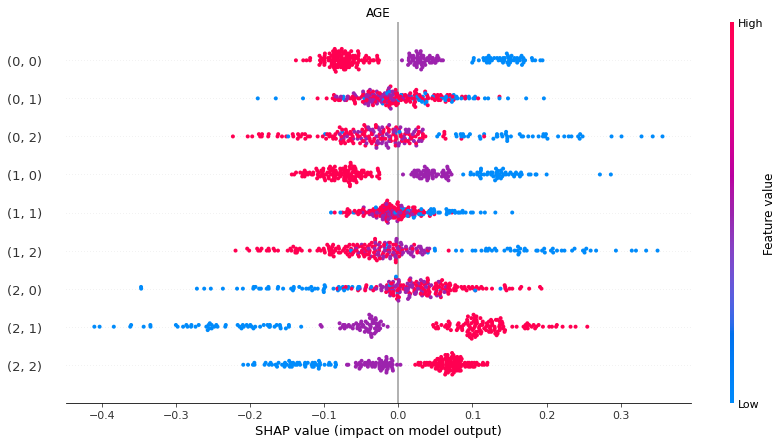

In [25]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[8:9]])

PTRATIO seems to have the biggest positive influences on instances with high feature values for classes $(1,2)$ and $(2,1)$.

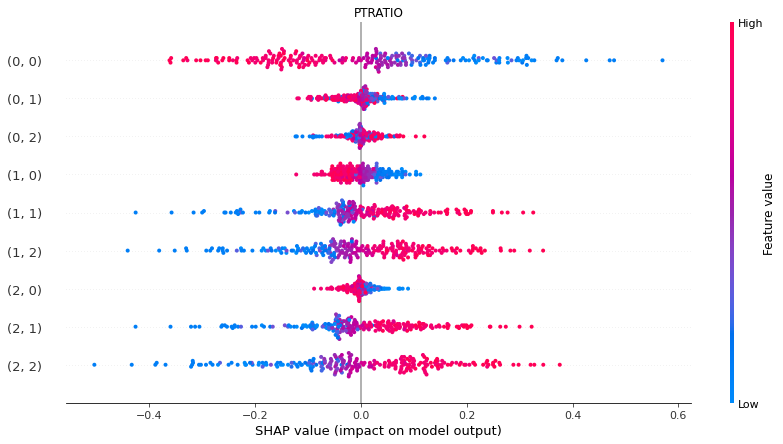

In [26]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[9:10]])

NOX may be disregarded because of its small influences.

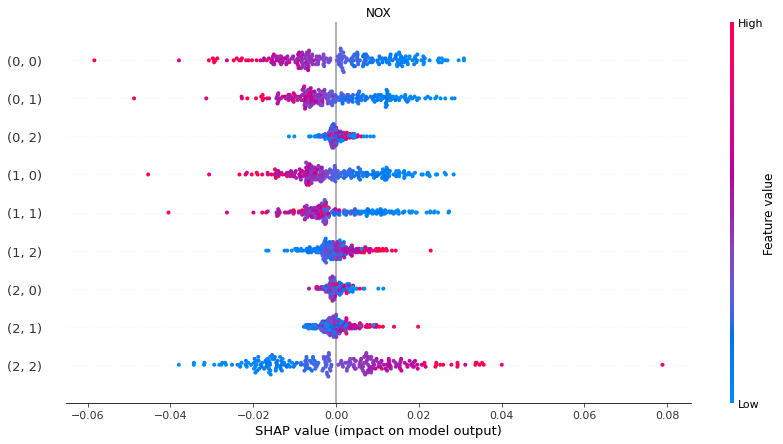

In [27]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[10:]])

## Feature effects

### Individual explanations

Now we plot the feature effects of the most important feature (LSTAT) for both classifiers and the subtracted SHAP values. Instances with different predictions are colored red. We can see, that they are within the value range 5 and 20, which is the part where the classifiers have to decide between either class 0 or 1 and class 1 or 2. Lower or higher values can be discriminated better.

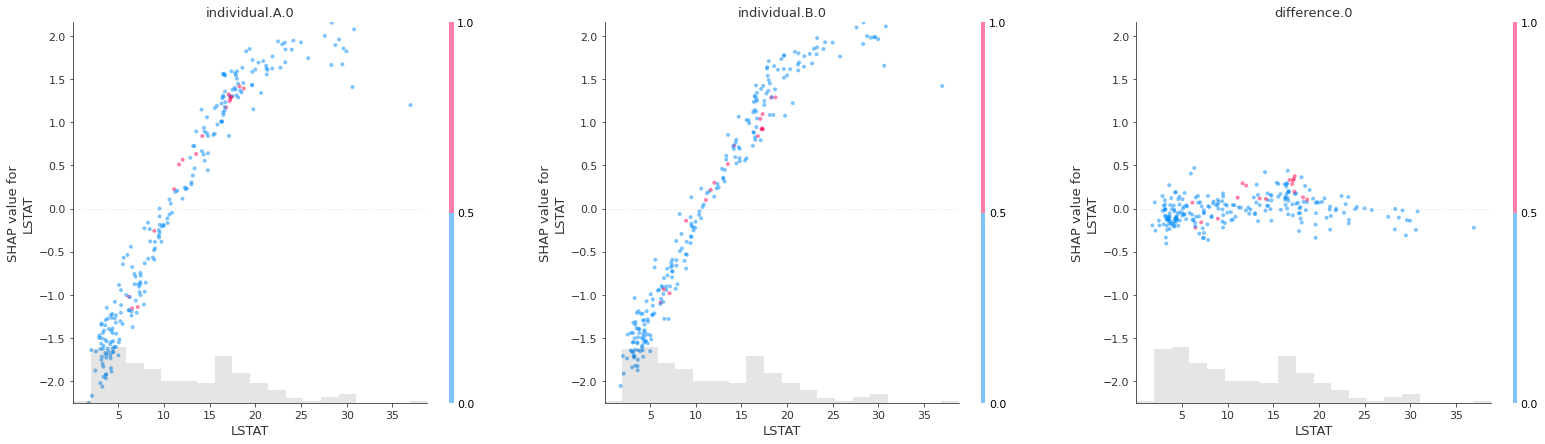

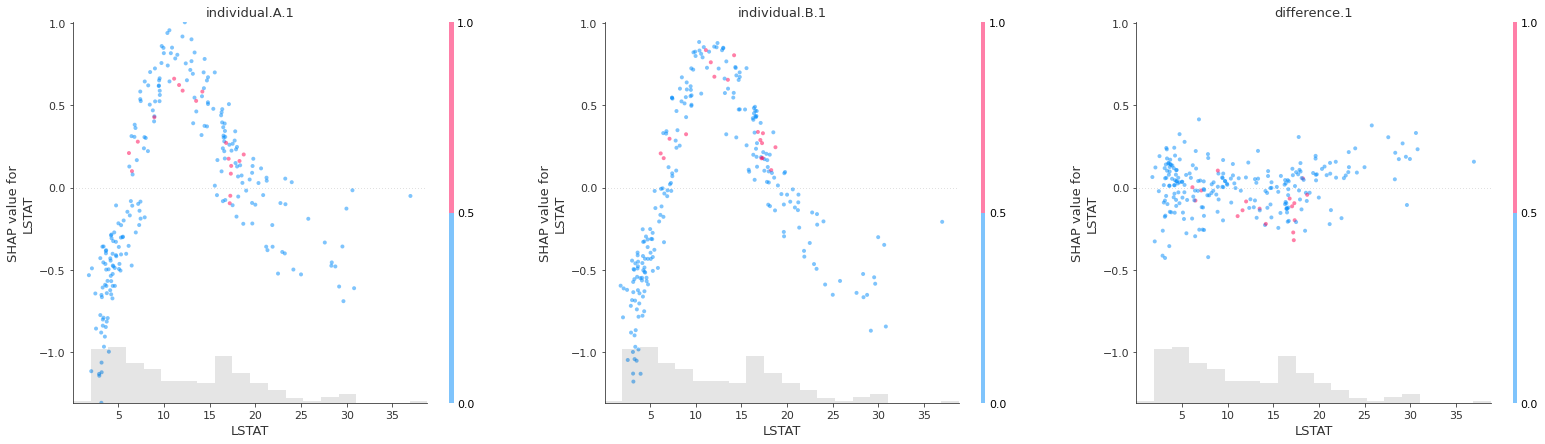

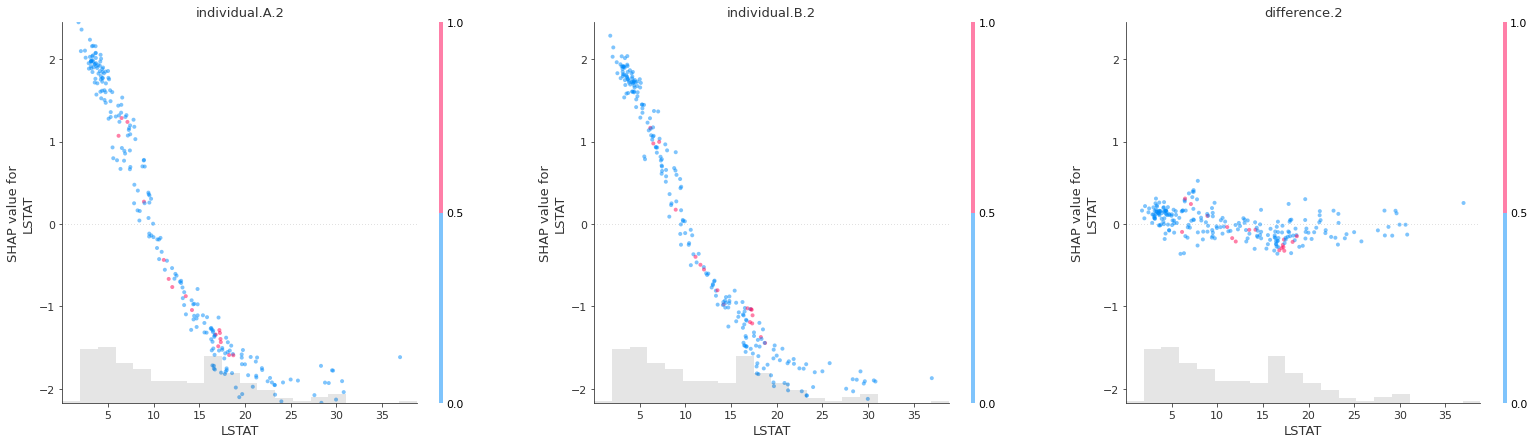

In [28]:
for class_idx in comparer.base_classes:
    plot_feature_effects(merge_explanations(individual=explanations.indiv.log_odds[:, [feature_order[0]], class_idx],
                                            difference=explanations.indiv_diff.log_odds[:, [feature_order[0]], class_idx]),
                         color=is_pred_diff, alpha=0.5)

**Compare with different explanability method:**
In the following plots, classic ICE (Individual Conditional Expectation) curves and their aggregated form, PDPs (partial dependence plots) are shown for the feature LSTAT. Both are related to SHAP dependence plots, and confirm our findings in the previous plots. Please note, that the y-axis values are different. This is because, although both methods being related, SHAP values equal a mean centered version of PDPs. SHAP values further show vertical dispersion in case of interactions.

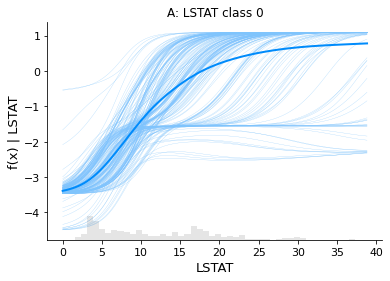

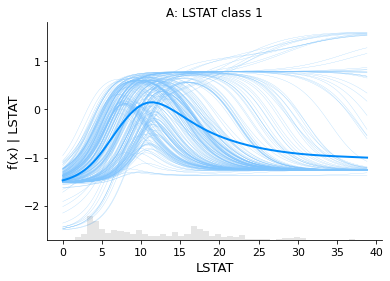

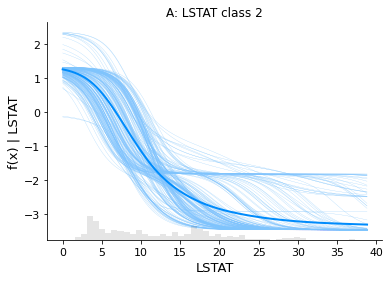

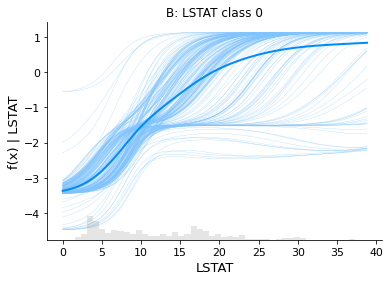

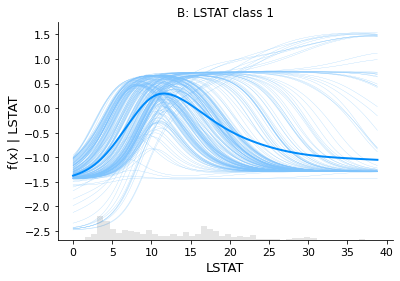

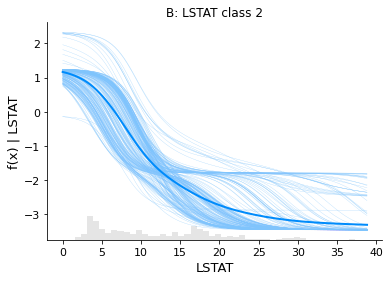

In [21]:
feature = 'LSTAT'
clf_name, class_idx = None, None
predict = lambda X: comparer.predict_log_odds_functions[clf_name](X)[:, class_idx]
for clf_name in ['A', 'B']:
    for class_idx in range(3):
        shap.partial_dependence_plot(feature, predict, X, show=False)
        plt.title(f'{clf_name}: {feature} class {class_idx}')
        plt.show()

### Difference classifier explanations

We see the effects of LSTAT for confusion class $(0,1)$ in the higher part of the aforementioned range. If we increase the value of LSTAT for the instances, that were classified as $(0,1)$, the positive influence for $(0,0)$ gets bigger and lower for $(0,1)$, which should lead to them being classified as $(0,0)$. In the other direction, it's similar for class $(1,1)$.

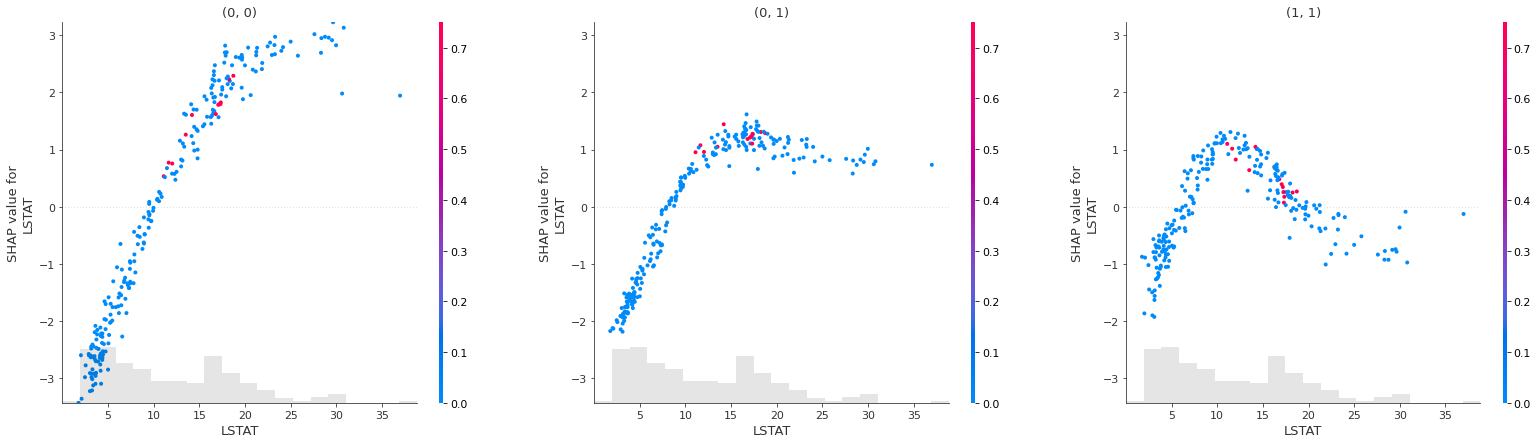

In [29]:
mask = mclass_diff == class_idx_of('(0, 1)')
shap_values = explanations.mclass_diff.log_odds[:, ['LSTAT']]
plot_feature_effects(shap_values[:, :, '(0, 0)'],
                     shap_values[:, :, '(0, 1)'],
                     shap_values[:, :, '(1, 1)'], color=mask)

Again, PDPs confirm the previous findings.

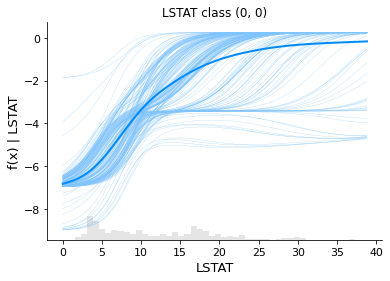

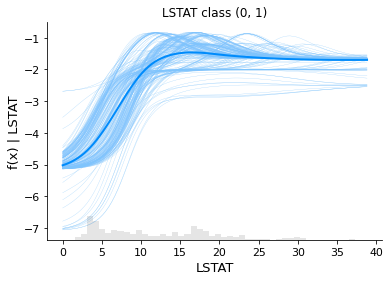

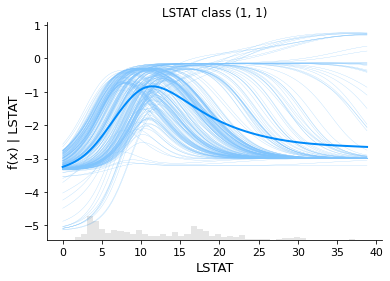

In [24]:
feature = 'LSTAT'
class_idx = None
predict = lambda X: comparer.predict_mclass_diff_log_odds(X)[:, class_idx]
for class_name in ['(0, 0)', '(0, 1)', '(1, 1)']:
    class_idx = class_idx_of(class_name)
    shap.partial_dependence_plot(feature, predict, X, show=False)
    plt.title(f'{feature} class {class_name}')
    plt.show()

By trial and error we see that when increasing the value of LSTAT for each instance different predictions to 19.2, both classifiers predict 0, and when decreasing the value to 10.2, both predict 1. So in this range, there might occur differences.

In [30]:
d = explanations.mclass_diff.log_odds[mask].data.copy()
d[:, feature_idx_of('LSTAT')] = 19.2
p = comparer.predict_mclass_diff(d)
comparer.class_names[p]

array(['(0, 0)', '(0, 0)', '(0, 0)', '(0, 0)', '(0, 0)', '(0, 0)',
       '(0, 0)', '(0, 0)', '(0, 0)', '(0, 0)', '(0, 0)', '(0, 0)',
       '(0, 0)'], dtype='<U6')

In [31]:
d = explanations.mclass_diff.log_odds[mask].data.copy()
d[:, feature_idx_of('LSTAT')] = 10.2
p = comparer.predict_mclass_diff(d)
comparer.class_names[p]

array(['(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)',
       '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)',
       '(1, 1)'], dtype='<U6')

Looking at the instances, that were classified as $(2,1)$, we expect similar effects.

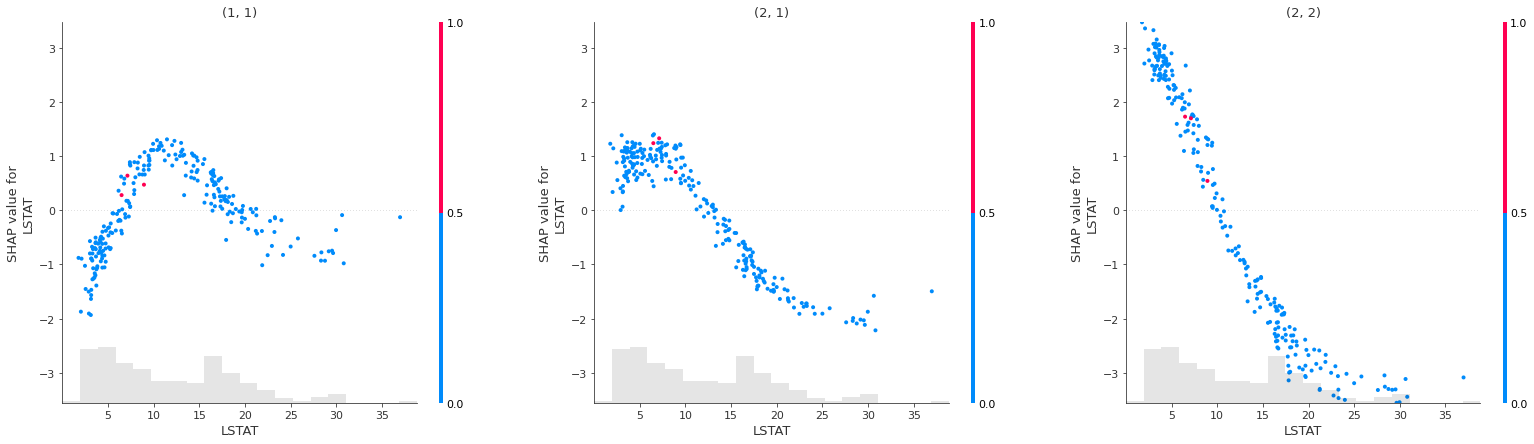

In [32]:
mask = mclass_diff == class_idx_of('(2, 1)')
shap_values = explanations.mclass_diff.log_odds[:, ['LSTAT']]
plot_feature_effects(shap_values[:, :, '(1, 1)'],
                     shap_values[:, :, '(2, 1)'],
                     shap_values[:, :, '(2, 2)'], color=mask)

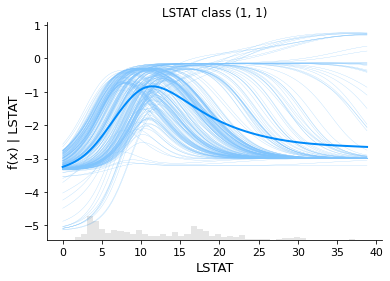

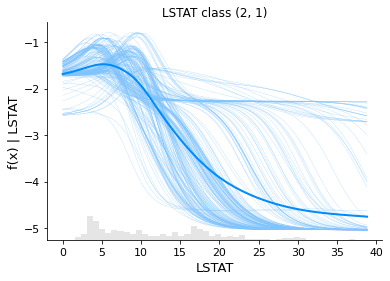

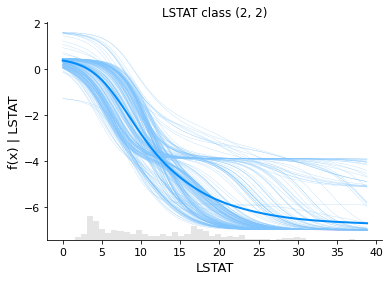

In [23]:
feature = 'LSTAT'
class_idx = None
predict = lambda X: comparer.predict_mclass_diff_log_odds(X)[:, class_idx]
for class_name in ['(1, 1)', '(2, 1)', '(2, 2)']:
    class_idx = class_idx_of(class_name)
    shap.partial_dependence_plot(feature, predict, X, show=False)
    plt.title(f'{feature} class {class_name}')
    plt.show()

Increasing LSTAT to 9.1, both classifiers predict 1, decreasing it to 5.9, both predict 2.

In [33]:
d = explanations.mclass_diff.log_odds[mask].data.copy()
d[:, feature_idx_of('LSTAT')] = 9.1
p = comparer.predict_mclass_diff(d)
comparer.class_names[p]

array(['(1, 1)', '(1, 1)', '(1, 1)'], dtype='<U6')

In [34]:
d = explanations.mclass_diff.log_odds[mask].data.copy()
d[:, feature_idx_of('LSTAT')] = 5.9
p = comparer.predict_mclass_diff(d)
comparer.class_names[p]

array(['(2, 2)', '(2, 2)', '(2, 2)'], dtype='<U6')

For class $(1,2)$, the effects look very much the same.

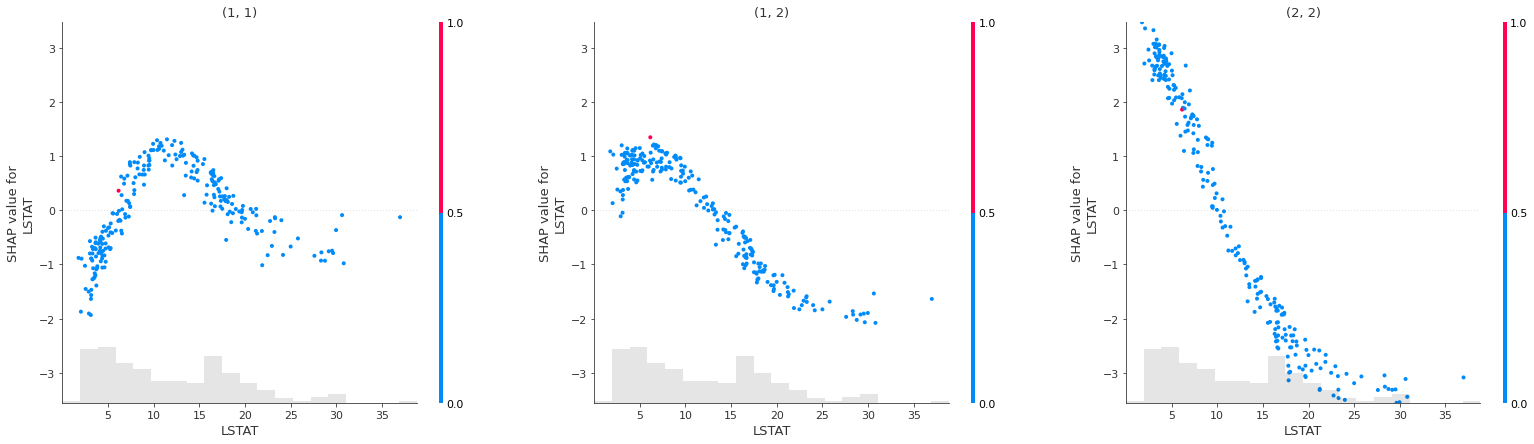

In [35]:
mask = mclass_diff == class_idx_of('(1, 2)')
shap_values = explanations.mclass_diff.log_odds[:, ['LSTAT']]
plot_feature_effects(shap_values[:, :, '(1, 1)'],
                     shap_values[:, :, '(1, 2)'],
                     shap_values[:, :, '(2, 2)'], color=mask)

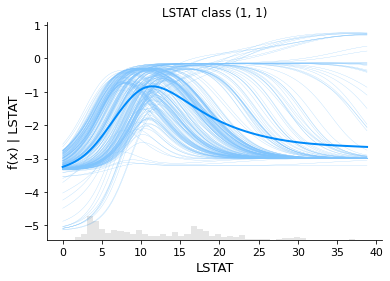

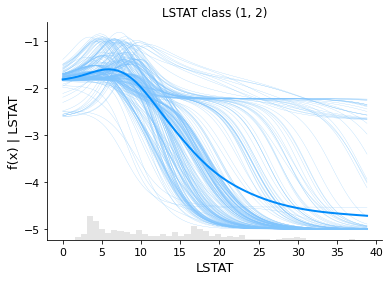

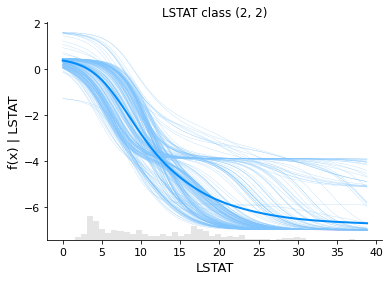

In [26]:
feature = 'LSTAT'
class_idx = None
predict = lambda X: comparer.predict_mclass_diff_log_odds(X)[:, class_idx]
for class_name in ['(1, 1)', '(1, 2)', '(2, 2)']:
    class_idx = class_idx_of(class_name)
    shap.partial_dependence_plot(feature, predict, X, show=False)
    plt.title(f'{feature} class {class_name}')
    plt.show()

Except that increasing LSTAT to 6.3 is enough to change the predictions to 1 for this instance, and decreasing it to 4.5 leads to both predicting 2.

In [36]:
d = explanations.mclass_diff.log_odds[mask].data.copy()
d[:, feature_idx_of('LSTAT')] = 6.3
p = comparer.predict_mclass_diff(d)
comparer.class_names[p]

array(['(1, 1)'], dtype='<U6')

In [37]:
d = explanations.mclass_diff.log_odds[mask].data.copy()
d[:, feature_idx_of('LSTAT')] = 4.5
p = comparer.predict_mclass_diff(d)
comparer.class_names[p]

array(['(2, 2)'], dtype='<U6')

Interestingly enough, we also see higher SHAP values for class $(1, 0)$ as well, where there are no different predictions. It's still good to know, that instances from 10 upwards are close to its decision boundary, but none are actually classified as this.

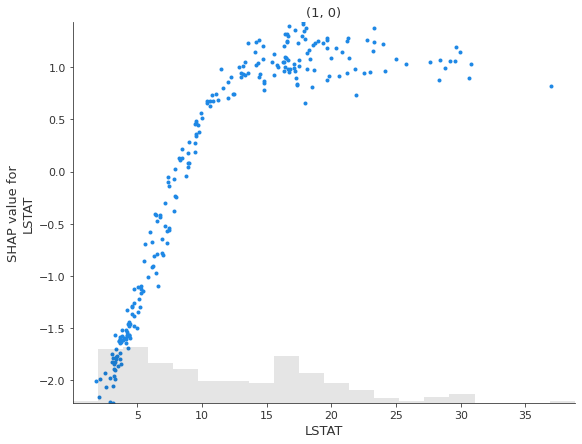

In [38]:
class_idx = np.where(comparer.class_names == '(1, 0)')[0][0]
plot_feature_effects(explanations.mclass_diff.log_odds[:, ['LSTAT'], class_idx])

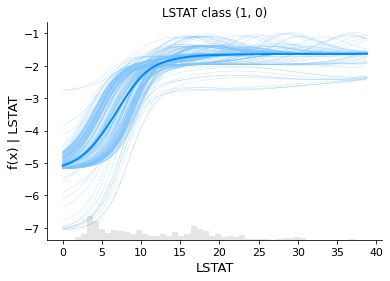

In [28]:
feature = 'LSTAT'
class_idx = None
predict = lambda X: comparer.predict_mclass_diff_log_odds(X)[:, class_idx]
for class_name in ['(1, 0)']:
    class_idx = class_idx_of(class_name)
    shap.partial_dependence_plot(feature, predict, X, show=False)
    plt.title(f'{feature} class {class_name}')
    plt.show()

For $(0,2)$ and $(2, 0)$, which also do not have any actual different predictions, it seems to have only smaller effects, quite possibly because these two classes lie further apart.

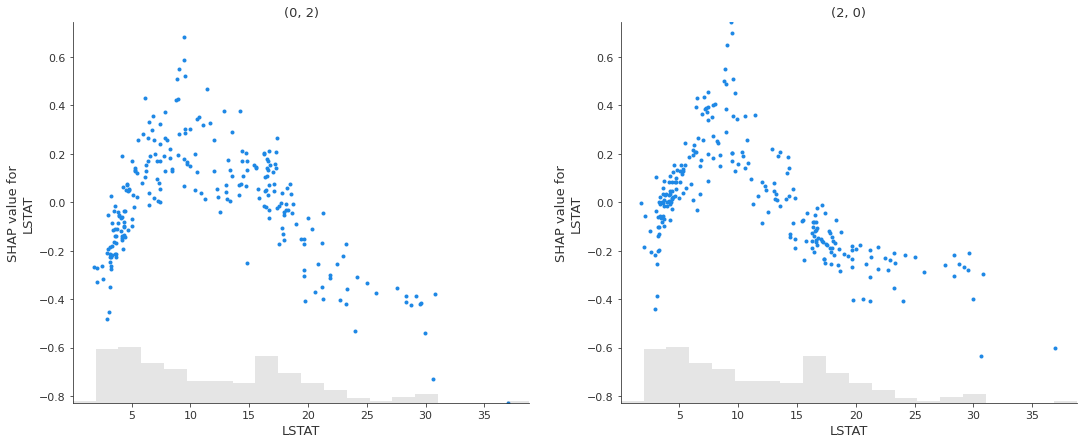

In [39]:
plot_feature_effects(explanations.mclass_diff.log_odds[:, ['LSTAT']][:, :, ['(0, 2)', '(2, 0)']])

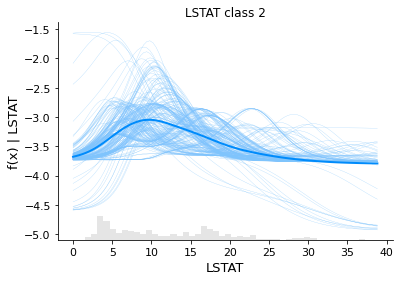

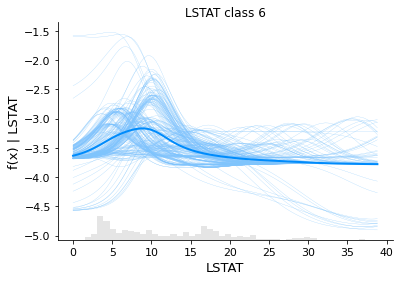

In [29]:
feature = 'LSTAT'
class_idx = None
predict = lambda X: comparer.predict_mclass_diff_log_odds(X)[:, class_idx]
for class_name in ['(0, 2)', '(2, 0)']:
    class_idx = class_idx_of(class_name)
    shap.partial_dependence_plot(feature, predict, X, show=False)
    plt.title(f'{feature} class {class_idx}')
    plt.show()

For ZN, we see that for most instances it's 0 and has a slight positive influence for $(0,1)$ and $(1,0)$. In turn, for those that have higher values, it has a slight positive influence for $(1,2)$ and $(2,1)$. And we notice, that all instances but one that have different predictions have a feature value of 0. We skip partial dependence plots, because they don't have any advantage over the already computed SHAP values.

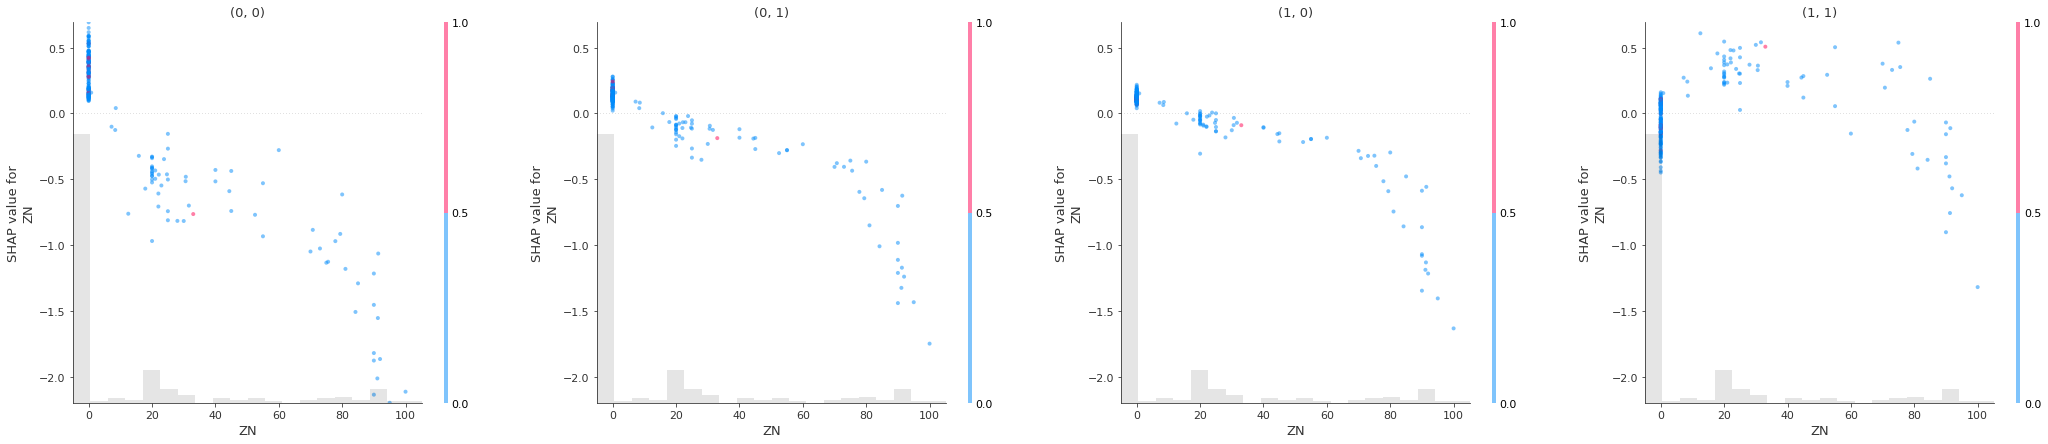

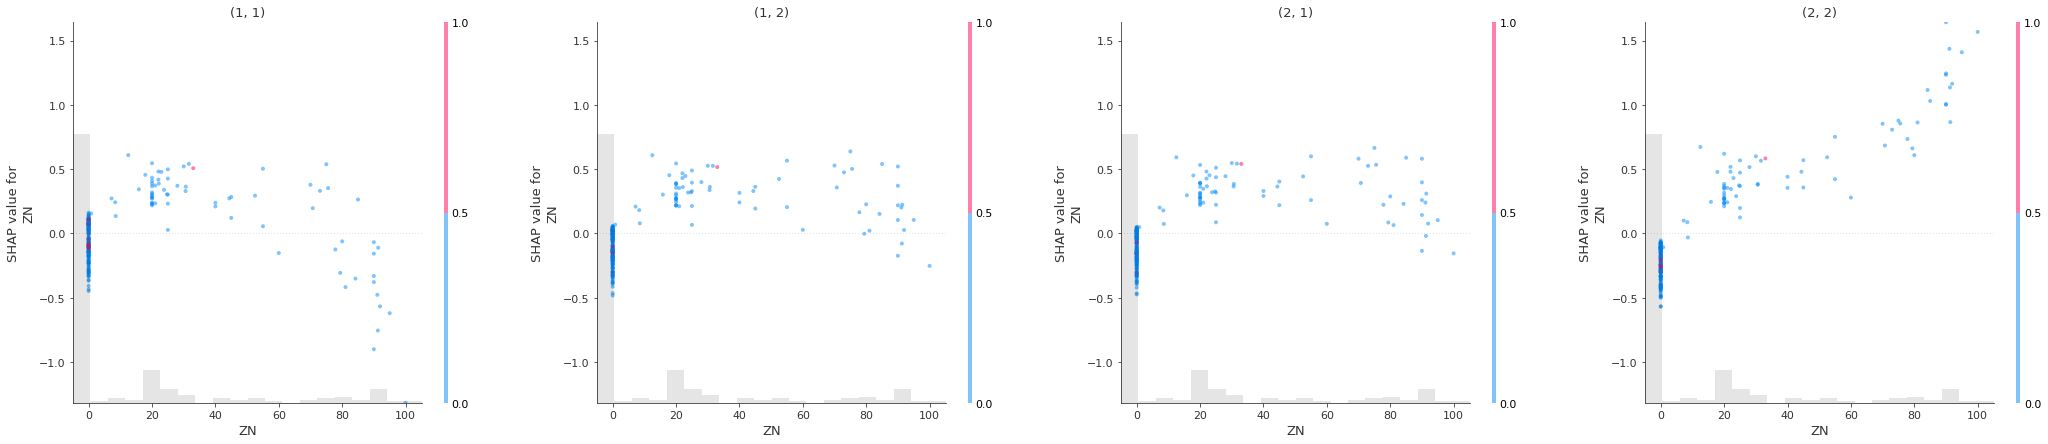

In [40]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[1:2]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

For INDUS, the effect is clearer. Higher values for this feature lead to higher SHAP values for $(0,1)$ and $(1,0)$, while lower values lead to higher SHAP values for $(1,2)$ and $(2,1)$.

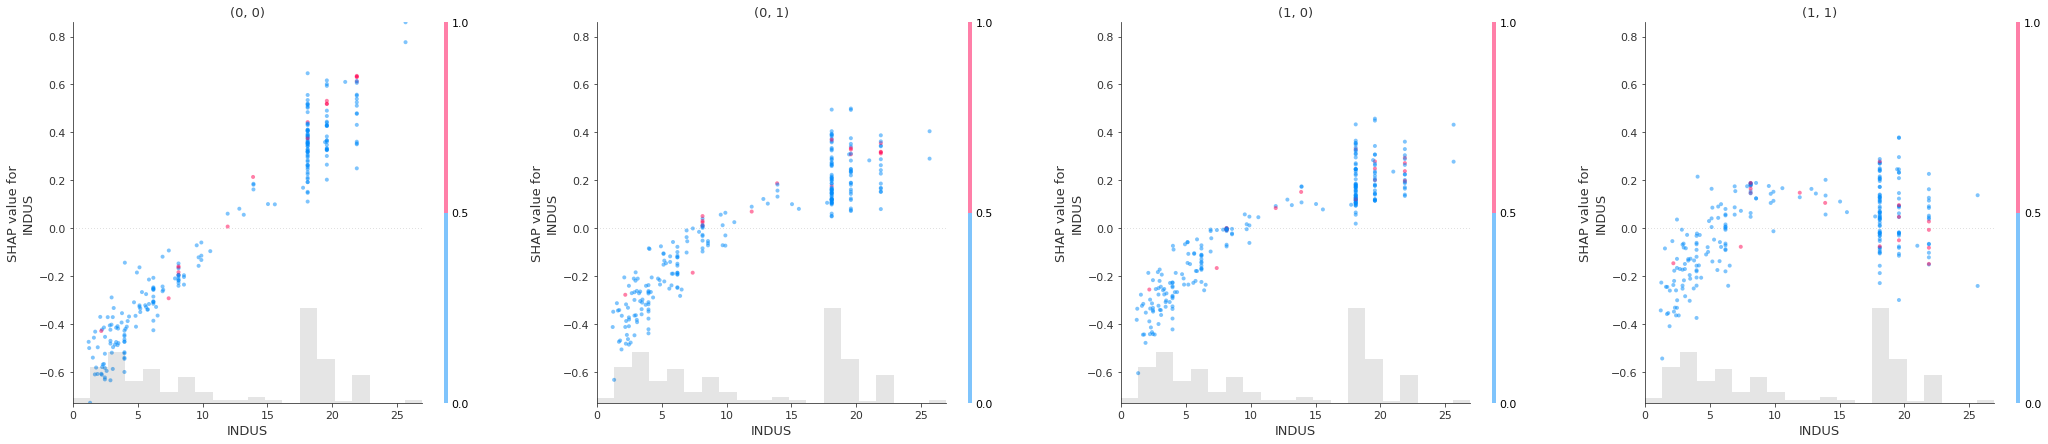

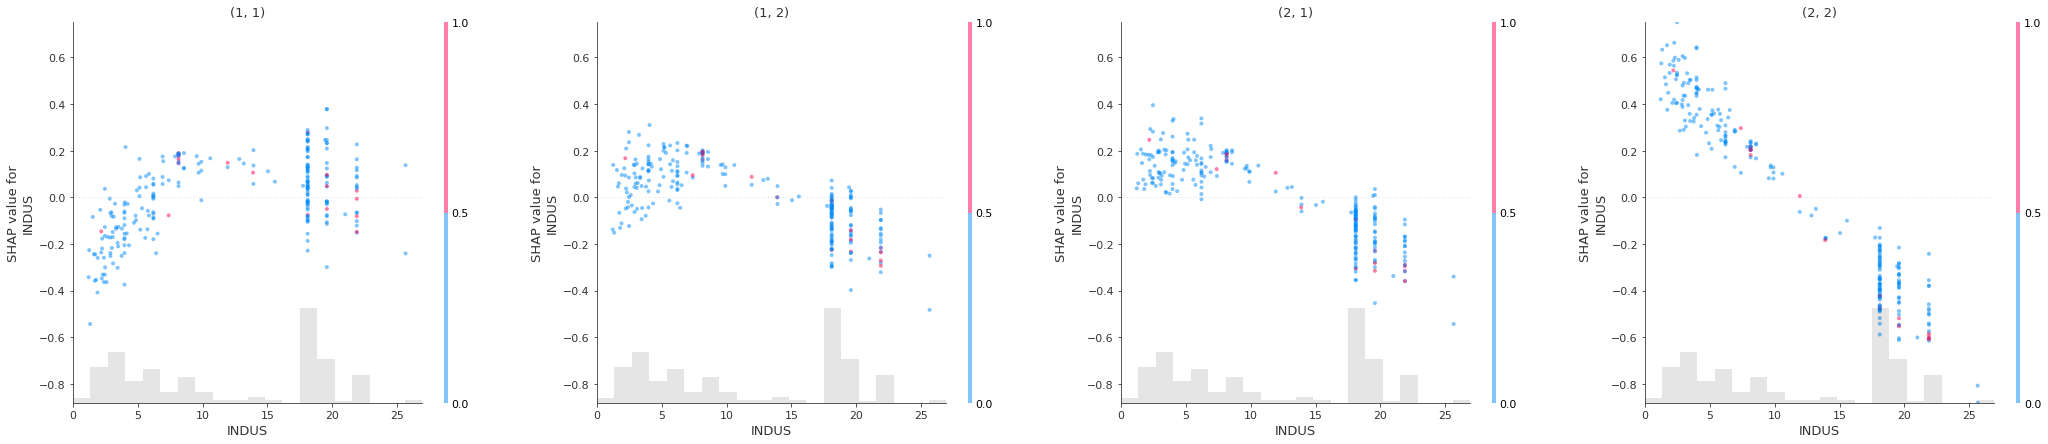

In [41]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[2:3]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

We see an effect for $(1,2)$ and $(2,1)$: the lower the value of CRIM, the higher the log odds for classifying as one of these classes.

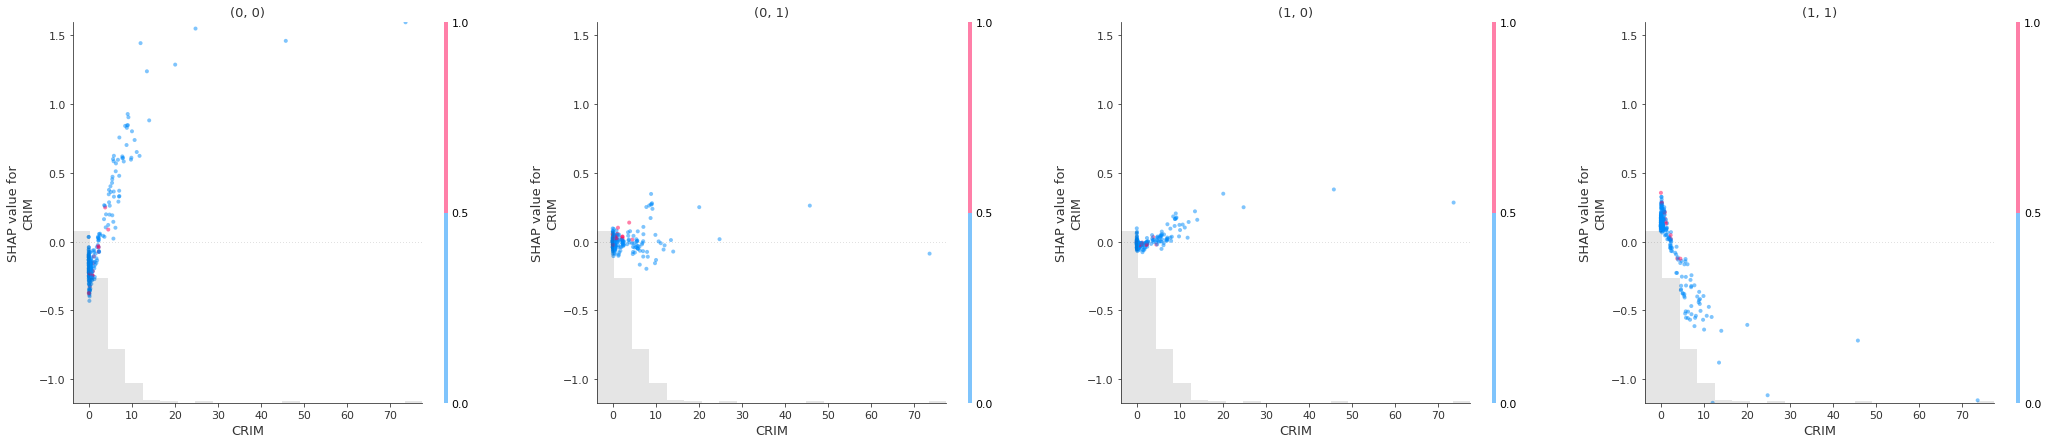

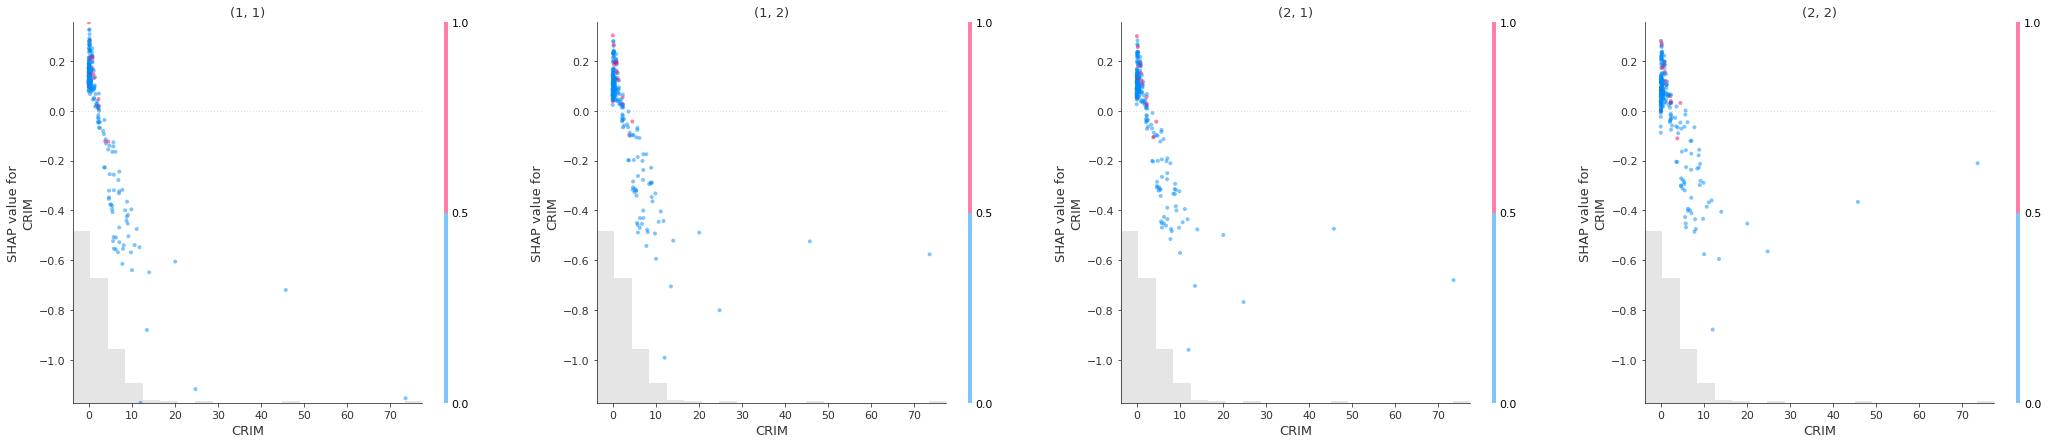

In [42]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[3:4]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

There's no clear effect on $(0,1)$ and $(1,0)$, but for high values of TAX (which are nearly all close to 700), we observe higher positive influence for classes $(1,2)$ and $(2,1)$.

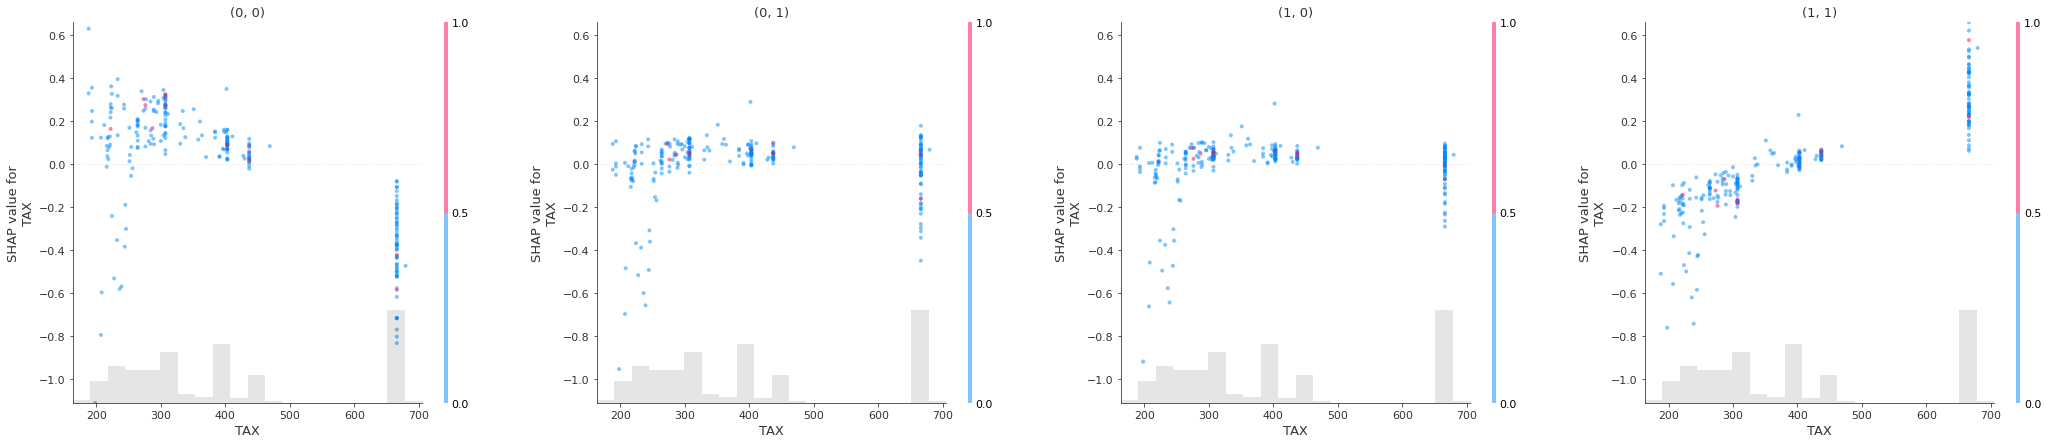

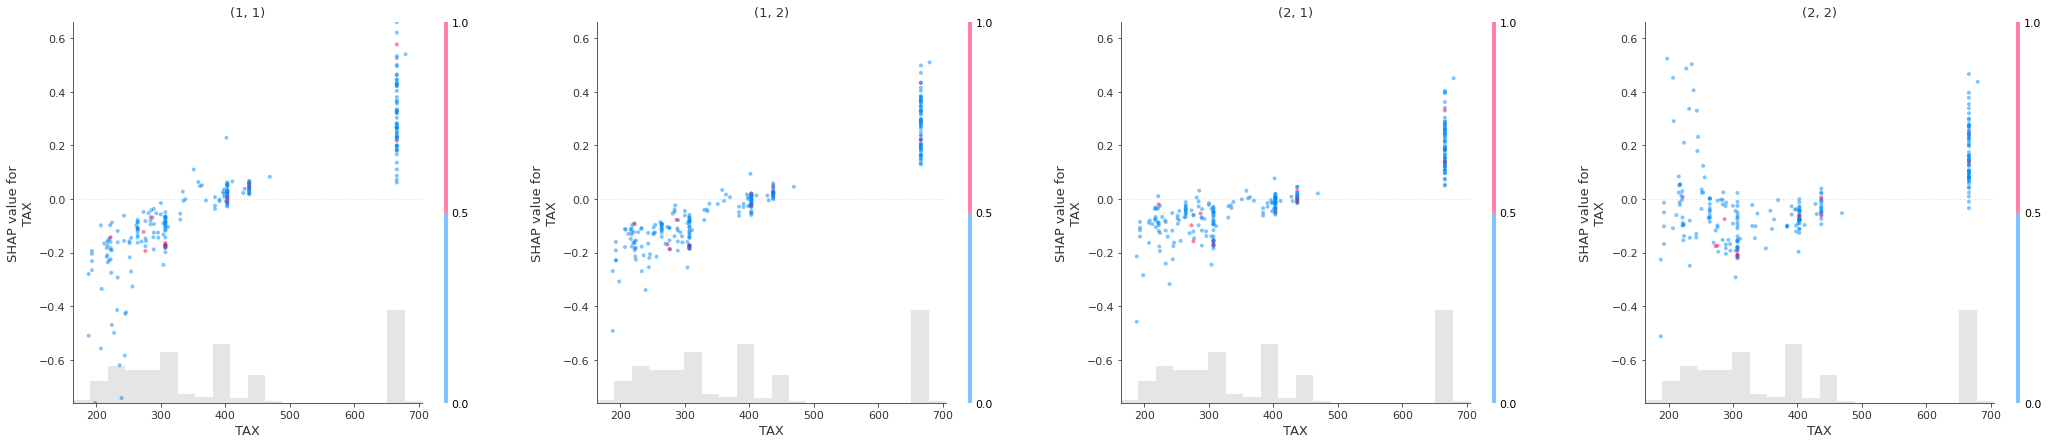

In [43]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[4:5]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

The effects of RM are higher for $(0,1)$ and $(1,0)$ than for $(1,2)$ and $(2,1)$. For the first two, low feature values have positive influence for the classes (note extreme instance on the left), and for the last two, high feature values have positive influence for the classes.

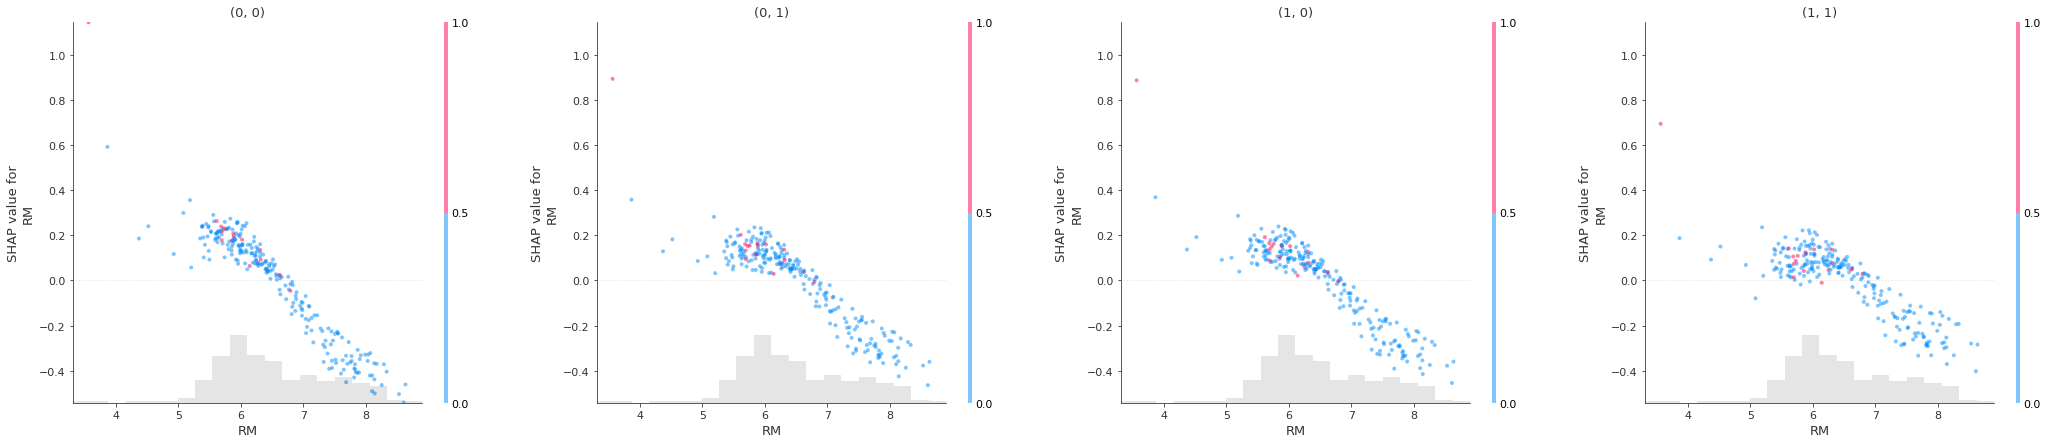

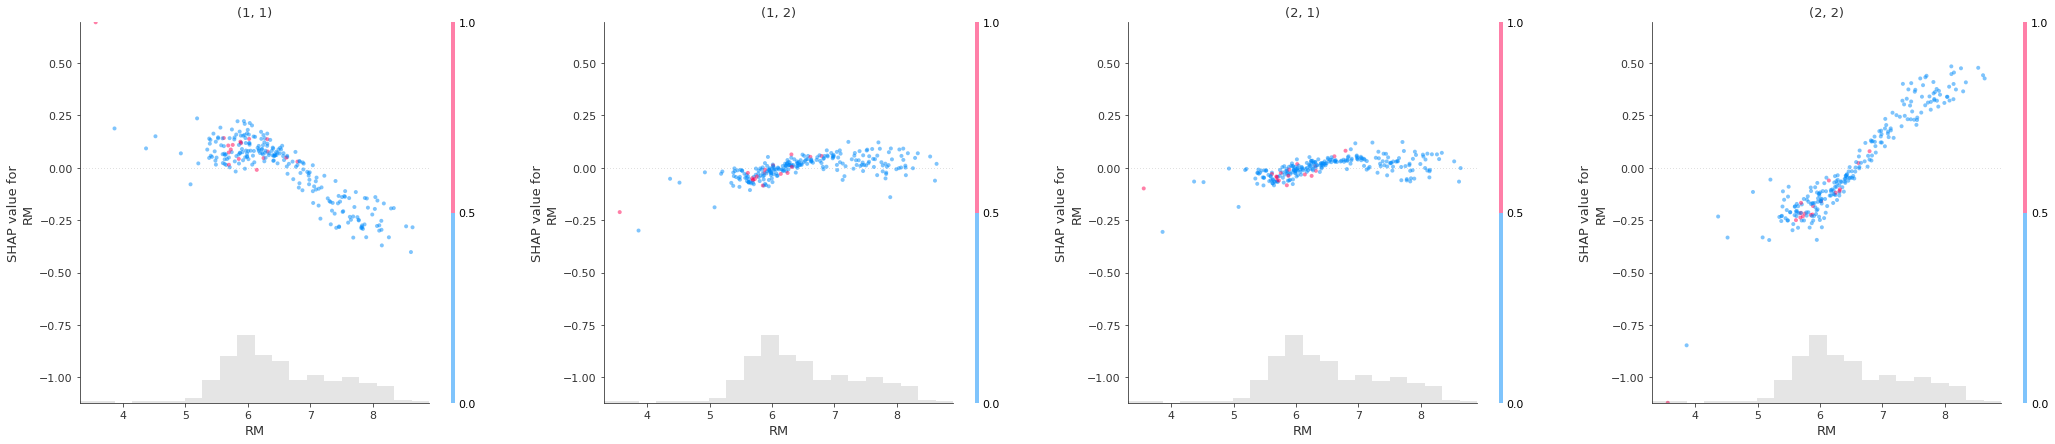

In [57]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[5:6]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

RAD only has positive influence for low values on classes $(0,1)$ and $(1,0)$.

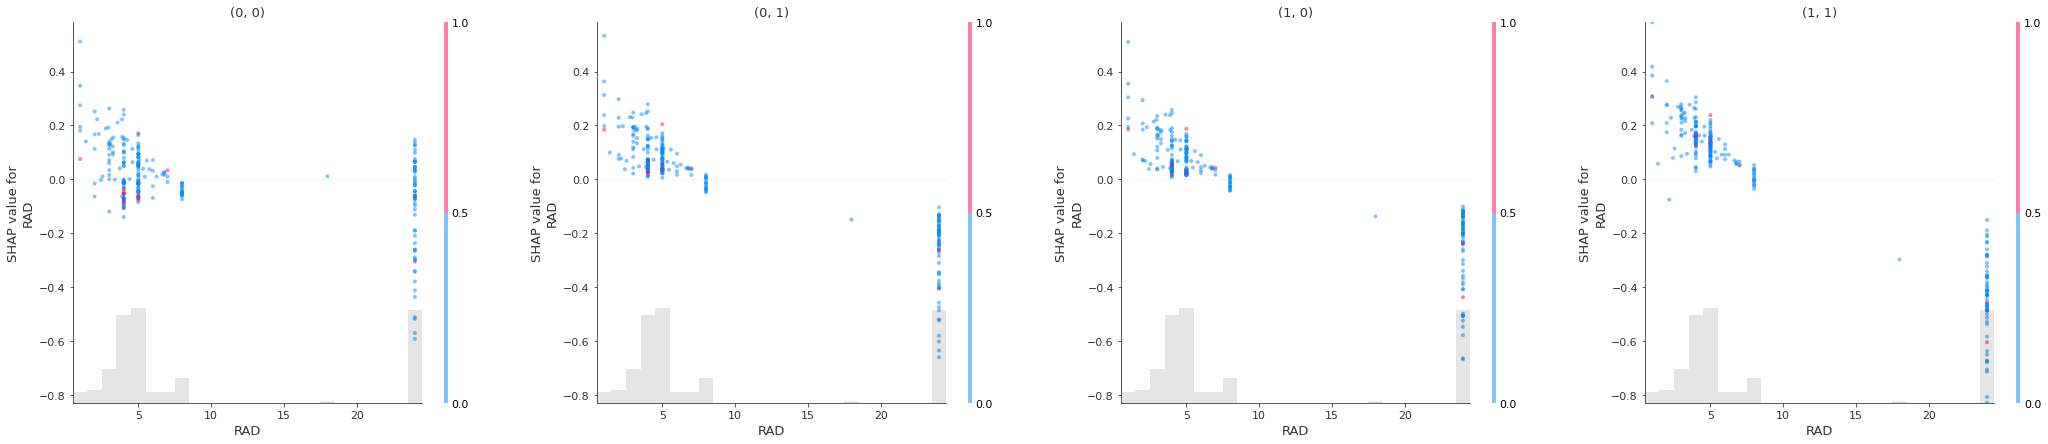

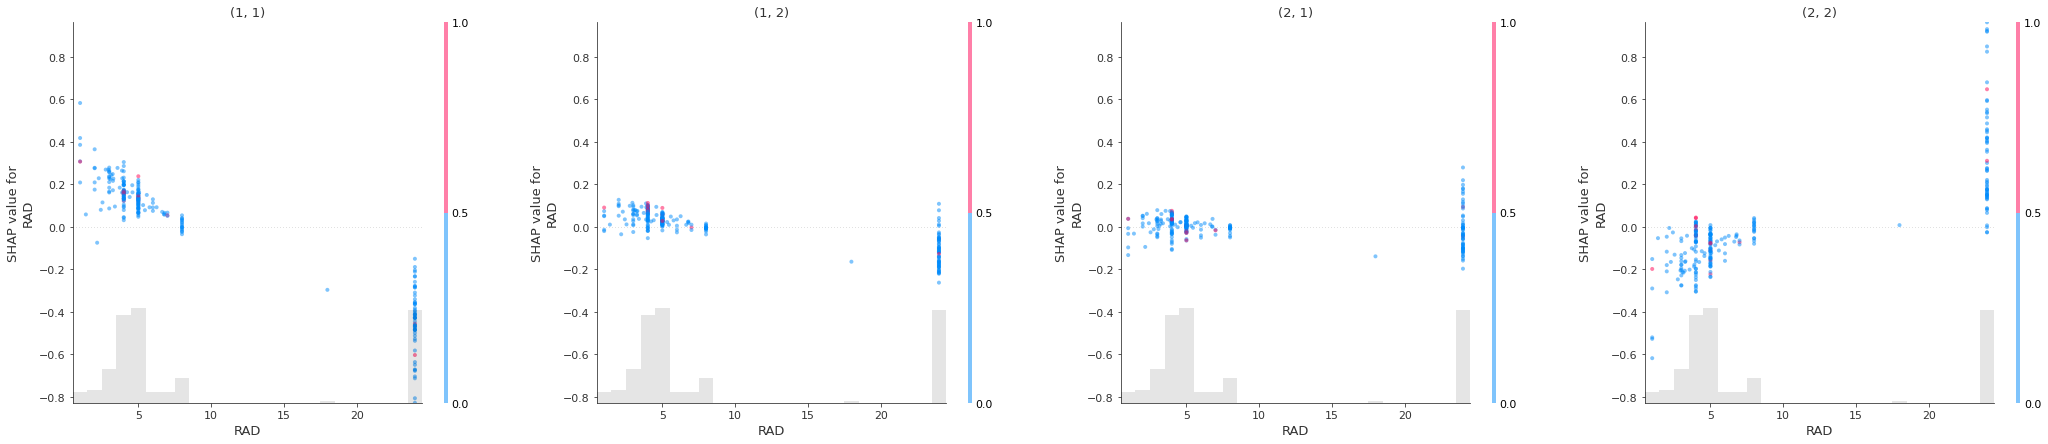

In [45]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[6:7]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

DIS has high positive influence for increasing feature values on $(0,1)$ and $(1,0)$.

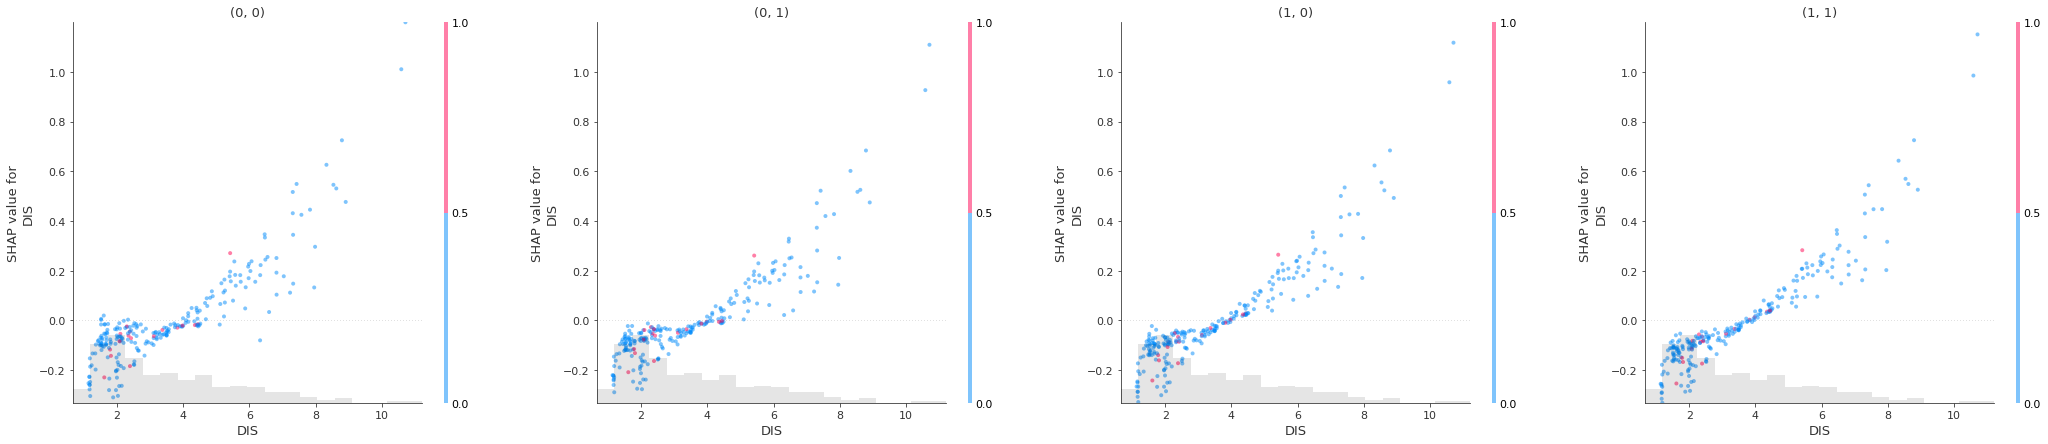

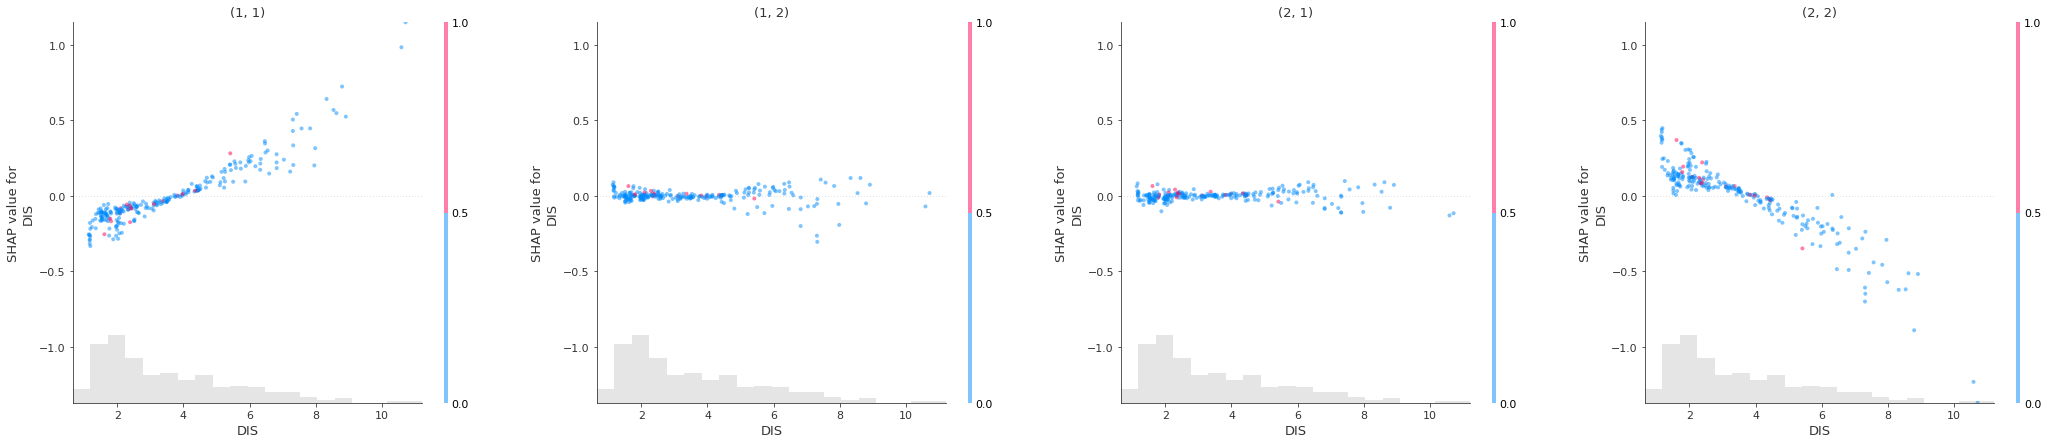

In [46]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[7:8]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

For $(0,1)$, the effect of AGE is not particularly clear, while low feature values having a positive influence on classes $(1,0)$ and $(1,2)$. High feature values have positive influence on class $(2,1)$. So this is the first feature, that has different effects on the classes $(1,2)$ and $(2,1)$.

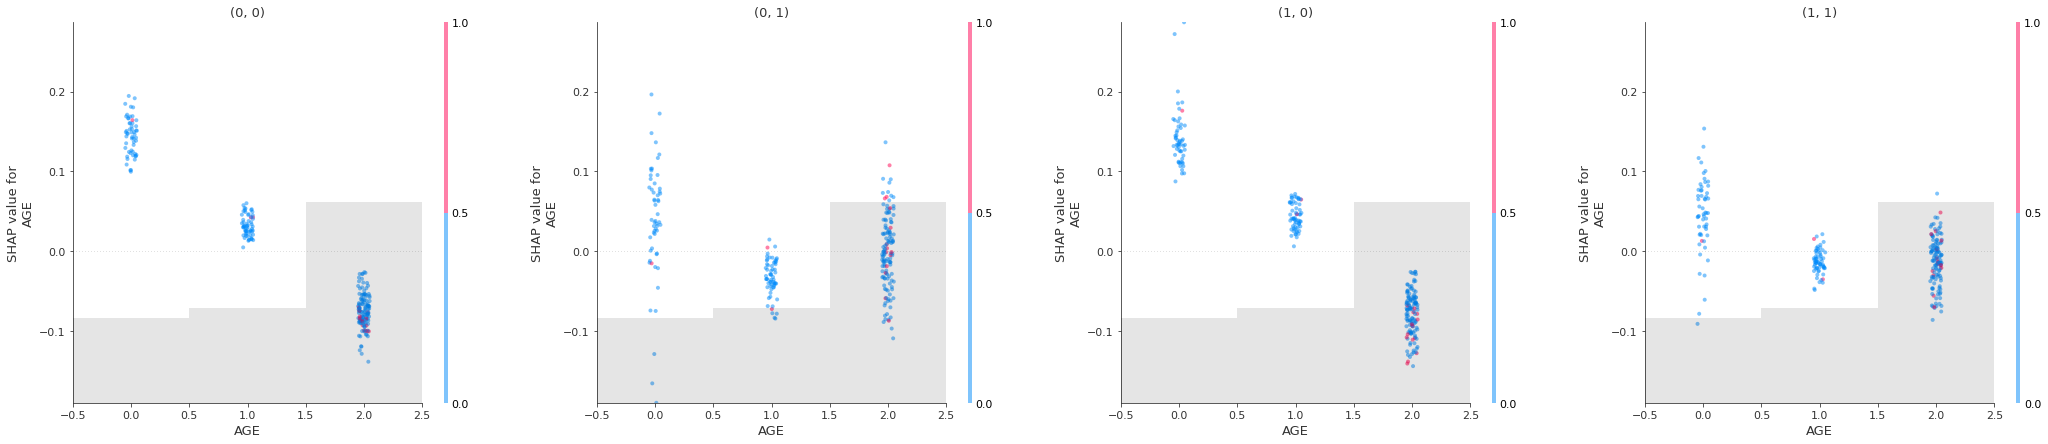

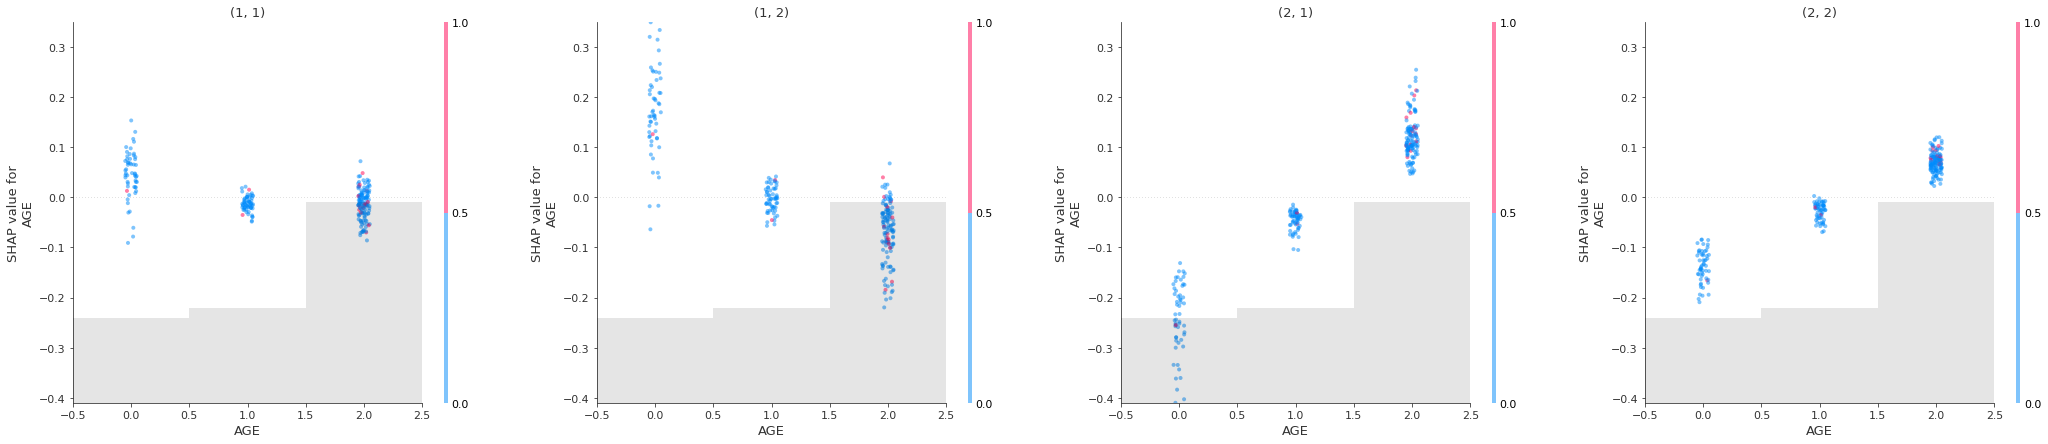

In [47]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[8:9]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

PTRATIO has slightly higher positive effects for low feature values on classes $(0,1)$ and $(1,0)$, and for high feature values on classes $(1,2)$ and $(2,1)$.

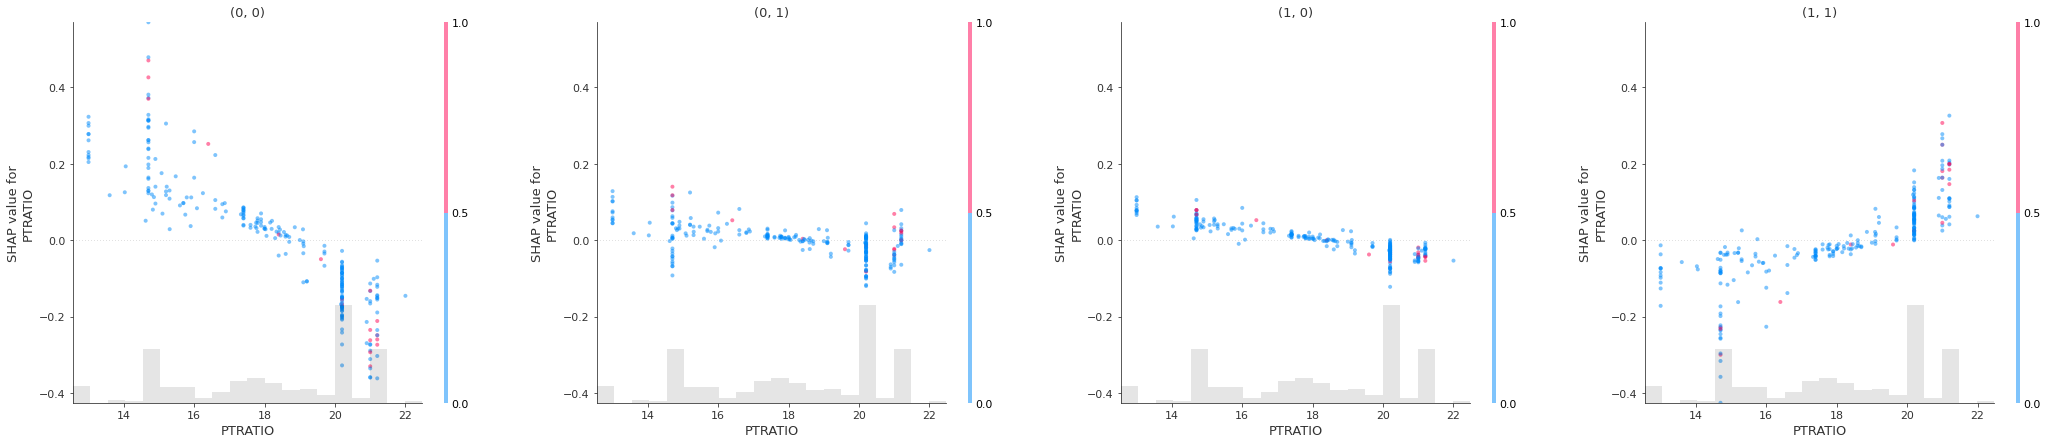

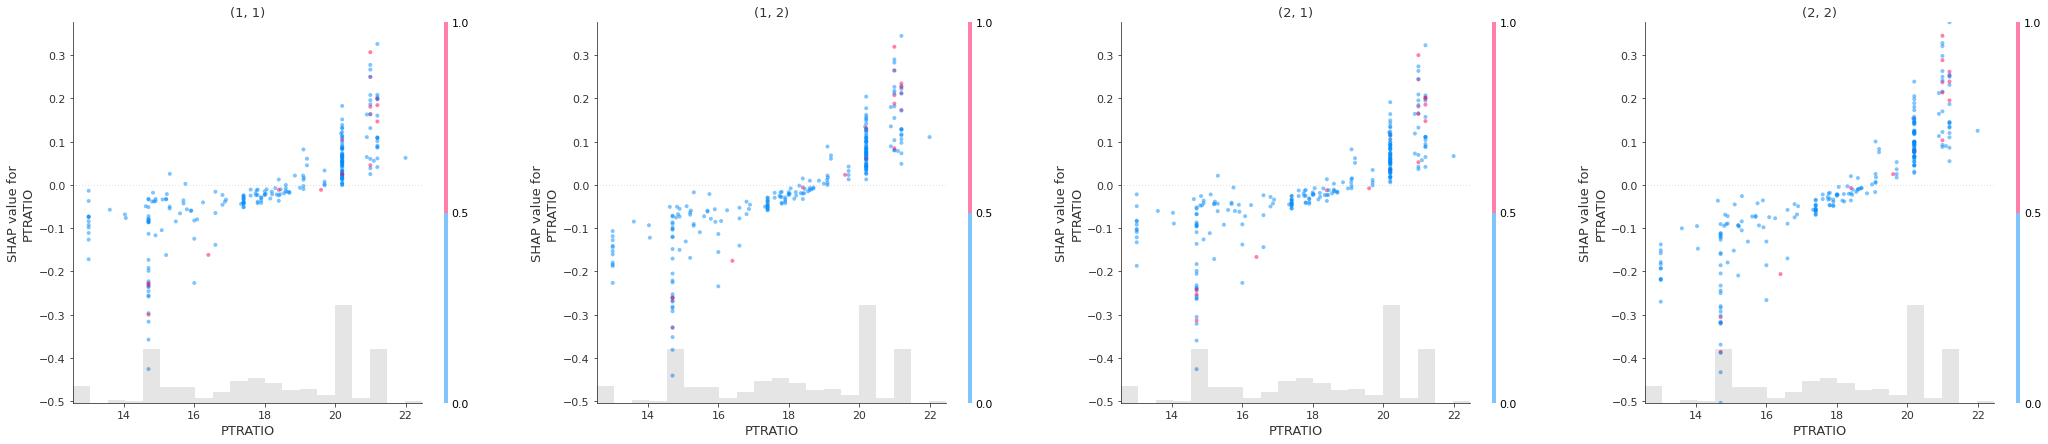

In [48]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[9:10]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

There are also effects of NOX, but they're really small compared to the other features.

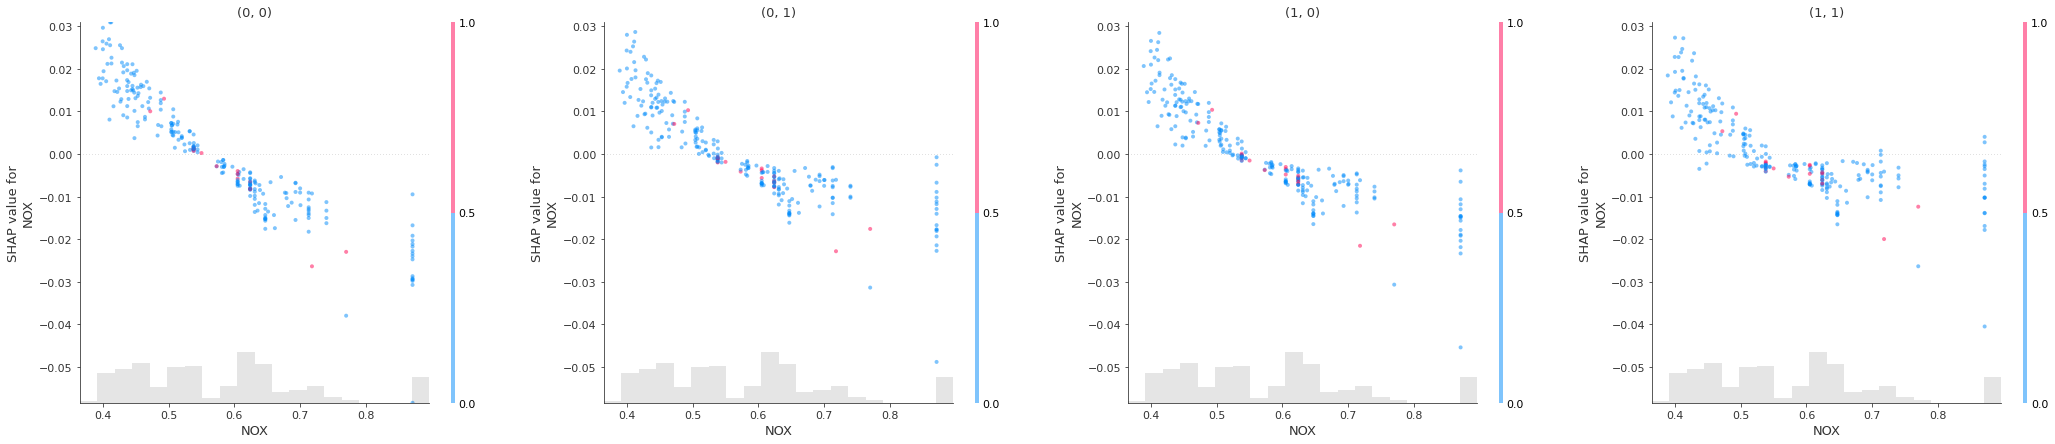

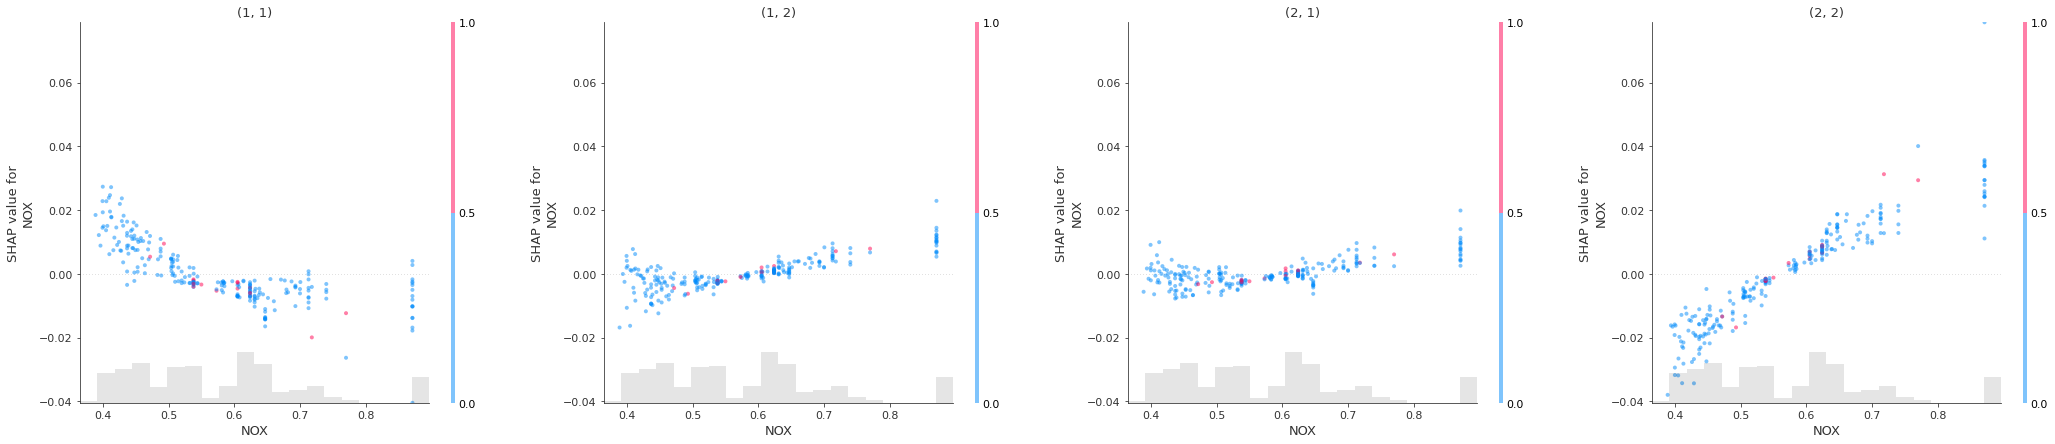

In [49]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[10:]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

# Conclusion

**About the two different explainability methods:**

Both being related I was able to confirm my findings in the SHAP dependence plots with the PDPs. But they had no advantage except being easier to read. SHAP values also show vertical dispersion, which is important to estimate how confident I can be about interpreting the effect for certain areas.

**The SHAP explanations presented here meet the following quality criteria**:
- contrastive - The feature effects plots of the difference classifier show not only the reasons for a specific confusion class, but also the reasons against the neighboring equality classes. Reasons in case of SHAP values are the payout to each feature for each instance in terms of the predicted outcome in log odds space in this case.
- selectiveness - By first aggregating the SHAP values per feature, we built a feature importance, that allowed us to select the most important features for further investigation. Anyway, I decided to analyze all features' SHAP value distribution and effects plots, but ordered by their importance for the observed differences.
- generalization - The presented limits of LSTAT and the effects around it apply to all instances with different predictions, so they are explanations with high generalization.

**Confidence in SHAP explanations:**

I'm pretty confident (1 on a scale of up to 4) about the decision boundaries of LSTAT, after investigating the SHAP values on a global level. For the other features, I can only guess (4 on a scale of up to 4), that the decision boundaries will be most likely in the areas of the highest SHAP values in the feature effects plots for the confusion classes. But these decision boundaries will not be the same for all instances. This is why subsets of instances need to be investigated further.

Further samples would be needed to investigate the decisision boundary between class 0 and 1, because the test set included none where A predicts 1 and B 0, although the SHAP value distributions and feature effects plots suggest that certain instances are close to the decision boundary.